In [44]:
import markcorr
import pandas as pd
import numpy as np
import altair as alt
from window import *
from pointPattern import *
import pandas as pd
import numpy as np
from breakpts import *
from sm_density import *
from window import *
from unnormdensity import *

In [45]:
from types import MappingProxyType
from pathlib import Path
import matplotlib.pyplot as plt
from typing import (
    TYPE_CHECKING,
    Any,
    Literal,
    Mapping,
    Sequence,
    Union,  # noqa: F401
)
from squidpy.gr._utils import (
    _assert_categorical_obs,
    _assert_non_empty_sequence,
    _get_valid_values,
)
import seaborn as sns
from anndata import AnnData
from squidpy.pl._color_utils import Palette_t, _get_palette, _maybe_set_colors
from squidpy.pl._utils import _heatmap, save_fig
from squidpy._constants._pkg_constants import Key
import scipy
from scipy.sparse import csr_matrix
import anndata
import squidpy as sq
from sklearn.metrics import auc

def line_intersect(Ax1, Ay1, Ax2, Ay2, Bx1, By1, Bx2, By2):
    """ returns a (x, y) tuple or None if there is no intersection """
    d = (By2 - By1) * (Ax2 - Ax1) - (Bx2 - Bx1) * (Ay2 - Ay1)
    if d:
        uA = ((Bx2 - Bx1) * (Ay1 - By1) - (By2 - By1) * (Ax1 - Bx1)) / d
        uB = ((Ax2 - Ax1) * (Ay1 - By1) - (Ay2 - Ay1) * (Ax1 - Bx1)) / d
    else:
        return
    if not(0 <= uA <= 1 and 0 <= uB <= 1):
        return
    x = Ax1 + uA * (Ax2 - Ax1)
    y = Ay1 + uA * (Ay2 - Ay1)

    return [x, y]

def _get_data(adata: AnnData, cluster_key: str, func_name: str, attr: str = "uns", **kwargs: Any) -> Any:
    key = getattr(Key.uns, func_name)(cluster_key, **kwargs)

    try:
        if attr == "uns":
            return adata.uns[key]
        elif attr == "obsm":
            return adata.obsm[key]
        else:
            raise ValueError(f"attr must be either 'uns' or 'obsm', got {attr}")
    except KeyError:
        raise KeyError(
            f"Unable to get the data from `adata.uns[{key!r}]`. "
            f"Please run `squidpy.gr.{func_name}(..., cluster_key={cluster_key!r})` first."
        ) from None

def co_occurrence(
    adata: AnnData,
    cluster_key: str,
    palette: Palette_t = None,
    clusters: str | Sequence[str] | None = None,
    legend_kwargs: Mapping[str, Any] = MappingProxyType({}),
    **kwargs: Any,
) -> None:
    """
    Plot co-occurrence probability ratio for each cluster.

    The co-occurrence is computed by :func:`squidpy.gr.co_occurrence`.

    Parameters
    ----------
    %(adata)s
    %(cluster_key)s
    clusters
        Cluster instances for which to plot conditional probability.
    %(cat_plotting)s
    legend_kwargs
        Keyword arguments for :func:`matplotlib.pyplot.legend`.
    kwargs
        Keyword arguments for :func:`seaborn.lineplot`.

    Returns
    -------
    %(plotting_returns)s
    """
    _assert_categorical_obs(adata, key=cluster_key)
    occurrence_data = _get_data(adata, cluster_key=cluster_key, func_name="co_occurrence")

    legend_kwargs = dict(legend_kwargs)
    if "loc" not in legend_kwargs:
        legend_kwargs["loc"] = "center left"
        legend_kwargs.setdefault("bbox_to_anchor", (1, 0.5))

    out = occurrence_data["occ"]
    interval = occurrence_data["interval"][1:]
    categories = adata.obs[cluster_key].cat.categories

    clusters = categories if clusters is None else clusters
    clusters = _assert_non_empty_sequence(clusters, name="clusters")
    clusters = sorted(_get_valid_values(clusters, categories))

    palette = _get_palette(adata, cluster_key=cluster_key, categories=categories, palette=palette)

    output = []
    for g in clusters:
        idx = np.where(categories == g)[0][0]
        if out is None:
          continue
        df = pd.DataFrame(out[idx, :, :].T, columns=categories).melt(var_name=cluster_key, value_name="probability")
        df["distance"] = np.tile(interval, len(categories))
        df1 = df[df["cell_type"]=="cell1"]
        df2 = df[df["cell_type"]=="cell2"]
        df2 = df2.reset_index()
        if np.isnan(df1["probability"][0]):
            df1["probability"][0]=0
        if np.isnan(df2["probability"][0]):
            df2["probability"][0]=0
        df1 = df1.fillna(method='ffill')
        df2 = df2.fillna(method='ffill')

        x1 = np.array(df1["distance"])
        y1 = np.array(df1["probability"])
        if y1.max()==y1.min():
            y1 = [0]*len(y1)
        else:
            y1 = (y1 - y1.min()) / (y1.max() - y1.min())
        
        x2 = np.array(df2["distance"])
        y2 = np.array(df2["probability"])
        if y2.max()==y2.min():
            y2 = [0]*len(y2)
        else:
            y2 = (y2 - y2.min()) / (y2.max() - y2.min())
        output.append(np.trapz(y=list(y1), x=list(x1)))
        output.append(np.trapz(y=list(y2), x=list(x2)))
    return output

def plt_co_occurrence(
    adata: AnnData,
    cluster_key: str,
    palette: Palette_t = None,
    clusters: str | Sequence[str] | None = None,
    legend_kwargs: Mapping[str, Any] = MappingProxyType({}),
    **kwargs: Any,
) -> None:
    _assert_categorical_obs(adata, key=cluster_key)
    occurrence_data = _get_data(adata, cluster_key=cluster_key, func_name="co_occurrence")

    legend_kwargs = dict(legend_kwargs)
    if "loc" not in legend_kwargs:
        legend_kwargs["loc"] = "center left"
        legend_kwargs.setdefault("bbox_to_anchor", (1, 0.5))

    out = occurrence_data["occ"]
    interval = occurrence_data["interval"][1:]
    categories = adata.obs[cluster_key].cat.categories

    clusters = categories if clusters is None else clusters
    clusters = _assert_non_empty_sequence(clusters, name="clusters")
    clusters = sorted(_get_valid_values(clusters, categories))

    palette = _get_palette(adata, cluster_key=cluster_key, categories=categories, palette=palette)

    for g in clusters:
        idx = np.where(categories == g)[0][0]
        if out is None:
          continue
        df = pd.DataFrame(out[idx, :, :].T, columns=categories).melt(var_name=cluster_key, value_name="probability")
        df["distance"] = np.tile(interval, len(categories))
        df1 = df[df["cell_type"]=="cell1"]
        df2 = df[df["cell_type"]=="cell2"]
        df2 = df2.reset_index()
        if np.isnan(df1["probability"][0]):
            df1["probability"][0]=0
        if np.isnan(df2["probability"][0]):
            df2["probability"][0]=0
        df1 = df1.fillna(method='ffill')
        df2 = df2.fillna(method='ffill')

        x1 = np.array(df1["distance"])
        y1 = np.array(df1["probability"])
        y1 = (y1 - y1.min()) / (y1.max() - y1.min())

        return pd.DataFrame({"r":x1,"kmm":y1})

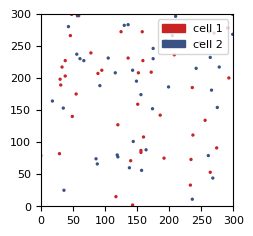

In [149]:
import random
import markcorr
plt.rcParams.update({'font.size': 8})
random.seed(34)
xrange = [0,330]
yrange = [0,330]
W = window(xrange,yrange)
x1 = []
y1 = []
x2 = []
y2 = []
mark1=[]
mark2=[]
for i in range(0,50):
    n = random.randint(0, 330)
    x1.append(n)
    n = random.randint(0, 330)
    y1.append(n)
    n = random.randint(0, 330)
    x2.append(n)
    n = random.randint(0, 330)
    y2.append(n)
for i in range(0,50):
    n = random.randint(1,5)
    mark1.append(1)
    n = random.randint(1,5)
    mark2.append(2)
x=x1+x2
y=y1+y2
d1 = [3]*len(x1)
d2 = [3]*len(x2)
fig, ax = plt.subplots()
plt.xticks(range(0, 330, 50))   
plt.yticks(range(0, 330, 50))
fig.set_size_inches(3, 2.5)
plt.axis('square')
c=plt.Circle((x1[0], x1[0]), 1.5, color="#c82423",label="cell 1")
ax.add_artist(c)
for i in range(1,len(x1)):
    x_p = x1[i]
    y_p = y1[i]
    d_p = d1[i]
    c=plt.Circle((x_p, y_p), d_p/2, color="#c82423")
    ax.add_artist(c)
    
c=plt.Circle((x2[0], x2[0]), 1.5, color="#3B5284",label="cell 2")
ax.add_artist(c)
for i in range(1,len(x2)):
    x_p = x2[i]
    y_p = y2[i]
    d_p = d2[i]
    c=plt.Circle((x_p, y_p), d_p/2, color="#3B5284")
    ax.add_artist(c)
plt.legend(loc="upper right")
plt.savefig("bm1_point.svg")
plt.show()

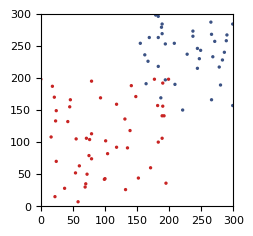

In [137]:
import random
import markcorr
plt.rcParams.update({'font.size': 8})
random.seed(34)
xrange = [0,330]
yrange = [0,330]
W = window(xrange,yrange)
x1 = []
y1 = []
x2 = []
y2 = []
mark1=[]
mark2=[]
for i in range(0,50):
    n = random.randint(0, 200)
    x1.append(n)
    n = random.randint(0, 200)
    y1.append(n)
    n = random.randint(150, 330)
    x2.append(n)
    n = random.randint(150, 330)
    y2.append(n)
for i in range(0,50):
    n = random.randint(1,5)
    mark1.append(1)
    n = random.randint(1,5)
    mark2.append(2)
x=x1+x2
y=y1+y2
d1 = [3]*len(x1)
d2 = [3]*len(x2)
fig, ax = plt.subplots()
plt.xticks(range(0, 330, 50))   
plt.yticks(range(0, 330, 50))
fig.set_size_inches(3, 2.5)
plt.axis('square')
for i in range(len(x1)):
    x_p = x1[i]
    y_p = y1[i]
    d_p = d1[i]
    c=plt.Circle((x_p, y_p), d_p/2, color="#c82423")
    ax.add_artist(c)
for i in range(len(x2)):
    x_p = x2[i]
    y_p = y2[i]
    d_p = d2[i]
    c=plt.Circle((x_p, y_p), d_p/2, color="#3B5284")
    ax.add_artist(c)
plt.savefig("bm2_point.svg")
plt.show()

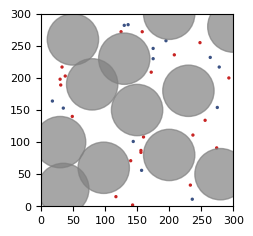

In [143]:
import random
import markcorr
plt.rcParams.update({'font.size': 8})
random.seed(34)
xrange = [0,330]
yrange = [0,330]
W = window(xrange,yrange)
x1 = []
y1 = []
x2 = []
y2 = []
mark1=[]
mark2=[]
for i in range(0,50):
    n = random.randint(0, 330)
    x1.append(n)
    n = random.randint(0, 330)
    y1.append(n)
    n = random.randint(0, 330)
    x2.append(n)
    n = random.randint(0, 330)
    y2.append(n)
for i in range(0,50):
    n = random.randint(1,5)
    mark1.append(1)
    n = random.randint(1,5)
    mark2.append(2)
x=x1+x2
y=y1+y2
adipocyte_x = [35,98,30,150,200,230,280,80,50,200,300,130]
adipocyte_y = [27,60,100,150,300,180,50,190,260,80,280,230]
rm_idx = []
for i in range(len(x1)):
    for j in range(len(adipocyte_x)):
        d2_0 = (x1[i]-adipocyte_x[j])**2 + (y1[i]-adipocyte_y[j])**2
        if d2_0 < 1681:
            rm_idx.append(i)
x1 = np.delete(x1,rm_idx).tolist()
y1 = np.delete(y1,rm_idx).tolist()
rm_idx = []
for i in range(len(x2)):
    for j in range(len(adipocyte_x)):
        d2_0 = (x2[i]-adipocyte_x[j])**2 + (y2[i]-adipocyte_y[j])**2
        if d2_0 < 1681:
            rm_idx.append(i)
x2 = np.delete(x2,rm_idx).tolist()
y2 = np.delete(y2,rm_idx).tolist()
d1 = [3]*len(x1)
d2 = [3]*len(x2)
fig, ax = plt.subplots()
plt.xticks(range(0, 330, 50))   
plt.yticks(range(0, 330, 50))
fig.set_size_inches(3, 2.5)
plt.axis('square')
for i in range(len(x1)):
    x_p = x1[i]
    y_p = y1[i]
    d_p = d1[i]
    c=plt.Circle((x_p, y_p), d_p/2, color="#c82423")
    ax.add_artist(c)
for i in range(len(x2)):
    x_p = x2[i]
    y_p = y2[i]
    d_p = d2[i]
    c=plt.Circle((x_p, y_p), d_p/2, color="#3B5284")
    ax.add_artist(c)
for i in range(len(adipocyte_x)):
    x_p = adipocyte_x[i]
    y_p = adipocyte_y[i]
    c=plt.Circle((x_p, y_p), 40, color="grey",alpha=0.7)
    ax.add_artist(c)
plt.savefig("bm3_point.svg")
plt.show()

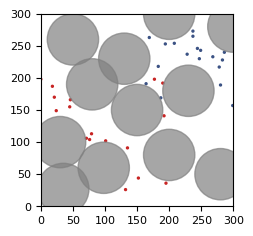

In [144]:
import random
import markcorr
plt.rcParams.update({'font.size': 8})
random.seed(34)
xrange = [0,330]
yrange = [0,330]
W = window(xrange,yrange)
x1 = []
y1 = []
x2 = []
y2 = []
mark1=[]
mark2=[]
for i in range(0,50):
    n = random.randint(0, 200)
    x1.append(n)
    n = random.randint(0, 200)
    y1.append(n)
    n = random.randint(150, 330)
    x2.append(n)
    n = random.randint(150, 330)
    y2.append(n)
for i in range(0,50):
    n = random.randint(1,5)
    mark1.append(1)
    n = random.randint(1,5)
    mark2.append(2)
x=x1+x2
y=y1+y2
adipocyte_x = [35,98,30,150,200,230,280,80,50,200,300,130]
adipocyte_y = [27,60,100,150,300,180,50,190,260,80,280,230]
rm_idx = []
for i in range(len(x1)):
    for j in range(len(adipocyte_x)):
        d2_0 = (x1[i]-adipocyte_x[j])**2 + (y1[i]-adipocyte_y[j])**2
        if d2_0 < 1681:
            rm_idx.append(i)
x1 = np.delete(x1,rm_idx).tolist()
y1 = np.delete(y1,rm_idx).tolist()
rm_idx = []
for i in range(len(x2)):
    for j in range(len(adipocyte_x)):
        d2_0 = (x2[i]-adipocyte_x[j])**2 + (y2[i]-adipocyte_y[j])**2
        if d2_0 < 1681:
            rm_idx.append(i)
x2 = np.delete(x2,rm_idx).tolist()
y2 = np.delete(y2,rm_idx).tolist()
d1 = [3]*len(x1)
d2 = [3]*len(x2)
fig, ax = plt.subplots()
plt.xticks(range(0, 330, 50))   
plt.yticks(range(0, 330, 50))
fig.set_size_inches(3, 2.5)
plt.axis('square')
for i in range(len(x1)):
    x_p = x1[i]
    y_p = y1[i]
    d_p = d1[i]
    c=plt.Circle((x_p, y_p), d_p/2, color="#c82423")
    ax.add_artist(c)
for i in range(len(x2)):
    x_p = x2[i]
    y_p = y2[i]
    d_p = d2[i]
    c=plt.Circle((x_p, y_p), d_p/2, color="#3B5284")
    ax.add_artist(c)
for i in range(len(adipocyte_x)):
    x_p = adipocyte_x[i]
    y_p = adipocyte_y[i]
    c=plt.Circle((x_p, y_p), 40, color="grey",alpha=0.7)
    ax.add_artist(c)
plt.savefig("bm4_point.svg")
plt.show()

In [46]:
import random
spatial = pd.DataFrame()
for s in range(0,100,1):
    random.seed(s)
    xrange = [0,330]
    yrange = [0,330]
    W = window(xrange,yrange)
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    mark1=[]
    mark2=[]
    for i in range(0,50):
        n = random.randint(0, 330)
        x1.append(n)
        n = random.randint(0, 330)
        y1.append(n)
        n = random.randint(0, 330)
        x2.append(n)
        n = random.randint(0, 330)
        y2.append(n)
    for i in range(0,50):
        n = random.randint(1,5)
        mark1.append(1)
        n = random.randint(1,5)
        mark2.append(2)
    x=x1+x2
    y=y1+y2
    
    mark_1 = mark1+[0]*len(mark2)
    mark_2 = [0]*len(mark1)+mark2
    new_spat = pd.DataFrame([x,y,mark_1,mark_2])
    spatial = pd.concat([spatial,new_spat.transpose()])
spatial.columns=["x","y","mark1","mark2"]
spatial.to_csv("./benchmark1_spatial.csv")

In [47]:
import random
spatial = pd.DataFrame()
for s in range(0,100,1):
    random.seed(s)
    xrange = [0,330]
    yrange = [0,330]
    W = window(xrange,yrange)
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    mark1=[]
    mark2=[]
    for i in range(0,50):
        n = random.randint(0, 200)
        x1.append(n)
        n = random.randint(0, 200)
        y1.append(n)
        n = random.randint(150, 330)
        x2.append(n)
        n = random.randint(150, 330)
        y2.append(n)
    for i in range(0,50):
        n = random.randint(1,5)
        mark1.append(1)
        n = random.randint(1,5)
        mark2.append(2)
    x=x1+x2
    y=y1+y2
    
    mark_1 = mark1+[0]*len(mark2)
    mark_2 = [0]*len(mark1)+mark2
    new_spat = pd.DataFrame([x,y,mark_1,mark_2])
    spatial = pd.concat([spatial,new_spat.transpose()])
spatial.columns=["x","y","mark1","mark2"]
spatial.to_csv("./benchmark2_spatial.csv")

In [95]:
import random
spatial = pd.DataFrame()
for s in range(0,100,1):
    random.seed(s)
    xrange = [0,330]
    yrange = [0,330]
    W = window(xrange,yrange)
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    for i in range(0,50):
        n = random.randint(0, 330)
        x1.append(n)
        n = random.randint(0, 330)
        y1.append(n)
        n = random.randint(0, 330)
        x2.append(n)
        n = random.randint(0, 330)
        y2.append(n)
    mark1 = []
    mark2 = []
    for i in range(0,50):
        n = random.randint(1,5)
        mark1.append(1)
        n = random.randint(1,5)
        mark2.append(2)

    adipocyte_x = [35,110,30,150,200,230,280,80,30]
    adipocyte_y = [27,60,100,150,300,220,50,190,260]
    rm_idx = []
    for i in range(len(x1)):
        for j in range(len(adipocyte_x)):
            d2_0 = (x1[i]-adipocyte_x[j])**2 + (y1[i]-adipocyte_y[j])**2
            if d2_0 < 1681:
                rm_idx.append(i)
    x1 = np.delete(x1,rm_idx).tolist()
    y1 = np.delete(y1,rm_idx).tolist()
    mark1 = np.delete(mark1,rm_idx).tolist()
    
    rm_idx = []
    for i in range(len(x2)):
        for j in range(len(adipocyte_x)):
            d2_0 = (x2[i]-adipocyte_x[j])**2 + (y2[i]-adipocyte_y[j])**2
            if d2_0 < 1681:
                rm_idx.append(i)
    x2 = np.delete(x2,rm_idx).tolist()
    y2 = np.delete(y2,rm_idx).tolist()
    mark2 = np.delete(mark2,rm_idx).tolist()

    x=x1+x2
    y=y1+y2
    x=x+[0]*(100-len(x))
    y=y+[0]*(100-len(y))
    
    mark_1 = mark1+[0]*len(mark2)
    mark_2 = [0]*len(mark1)+mark2
    new_spat = pd.DataFrame([x,y,mark_1,mark_2])
    spatial = pd.concat([spatial,new_spat.transpose()])
spatial.columns=["x","y","mark1","mark2"]
spatial.to_csv("./benchmark3_spatial.csv")

In [49]:
import random
spatial = pd.DataFrame()
for s in range(0,100,1):
    random.seed(s)
    xrange = [0,330]
    yrange = [0,330]
    W = window(xrange,yrange)
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    for i in range(0,50):
        n = random.randint(0, 200)
        x1.append(n)
        n = random.randint(0, 200)
        y1.append(n)
        n = random.randint(150, 330)
        x2.append(n)
        n = random.randint(150, 330)
        y2.append(n)
    mark1 = []
    mark2 = []
    for i in range(0,50):
        n = random.randint(1,5)
        mark1.append(1)
        n = random.randint(1,5)
        mark2.append(2)

    adipocyte_x = [35,110,30,150,200,230,280,80,30,200,300,130,270,180]
    adipocyte_y = [27,60,100,150,300,220,50,190,260,80,280,230,130,0]
    rm_idx = []
    for i in range(len(x1)):
        for j in range(len(adipocyte_x)):
            d2_0 = (x1[i]-adipocyte_x[j])**2 + (y1[i]-adipocyte_y[j])**2
            if d2_0 < 1681:
                rm_idx.append(i)
    x1 = np.delete(x1,rm_idx).tolist()
    y1 = np.delete(y1,rm_idx).tolist()
    mark1 = np.delete(mark1,rm_idx).tolist()
    
    rm_idx = []
    for i in range(len(x2)):
        for j in range(len(adipocyte_x)):
            d2_0 = (x2[i]-adipocyte_x[j])**2 + (y2[i]-adipocyte_y[j])**2
            if d2_0 < 1681:
                rm_idx.append(i)
    x2 = np.delete(x2,rm_idx).tolist()
    y2 = np.delete(y2,rm_idx).tolist()
    mark2 = np.delete(mark2,rm_idx).tolist()

    x=x1+x2
    y=y1+y2
    x=x+[0]*(100-len(x))
    y=y+[0]*(100-len(y))
    
    mark_1 = mark1+[0]*len(mark2)
    mark_2 = [0]*len(mark1)+mark2
    new_spat = pd.DataFrame([x,y,mark_1,mark_2])
    spatial = pd.concat([spatial,new_spat.transpose()])
spatial.columns=["x","y","mark1","mark2"]
spatial.to_csv("./benchmark4_spatial.csv")

In [50]:
# benchmark1 : uniform distribute, without large cell
import random
spatial = pd.DataFrame()
with_size1 = pd.DataFrame(index=range(0,100),columns=['cell1 vs. cell1','cell1 vs. cell2','cell2 vs. cell1','cell2 vs. cell2'])
without_size1 = pd.DataFrame(index=range(0,100),columns=['cell1 vs. cell1','cell1 vs. cell2','cell2 vs. cell1','cell2 vs. cell2'])
squidpy1 = pd.DataFrame(index=range(0,100),columns=['cell1 vs. cell1','cell1 vs. cell2','cell2 vs. cell1','cell2 vs. cell2'])
for s in range(0,100,1):
    random.seed(s)
    xrange = [0,330]
    yrange = [0,330]
    W = window(xrange,yrange)
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    for i in range(0,50):
        n = random.randint(0, 330)
        x1.append(n)
        n = random.randint(0, 330)
        y1.append(n)
        n = random.randint(0, 330)
        x2.append(n)
        n = random.randint(0, 330)
        y2.append(n)
    x=x1+x2
    y=y1+y2
    mark1 = []
    mark2 = []
    for i in range(0,50):
        n = random.randint(1,5)
        mark1.append(1)
        n = random.randint(1,5)
        mark2.append(2)
    d = [3]*len(x)

    mark_1 = mark1+[0]*len(mark2)
    mark_2 = [0]*len(mark1)+mark2
    mark = pd.DataFrame()
    mark["cell1"] = mark_1
    mark["cell2"] = mark_2
    
    new_spat = pd.DataFrame([x,y,mark_1,mark_2])
    spatial = pd.concat([spatial,new_spat.transpose()])
    # with size considered 
    p = pointPattern(x,y,d,W,mark)
    r, funs = markcorr.markcorr(p, saveImage=False,savefolder = "./", remove_zeros=False)
    iso, trans = {}, {}
    for i in funs:
        trans[i] = (funs[i][0])
        iso[i] = (funs[i][1])
    trans = pd.DataFrame(trans)
    trans["r"] = r
    for col in trans:
        if col == 'r':
            continue
        v = trans[col]
        v = (v - v.min()) / (v.max() - v.min())
        near_y = v[trans.r<10]
        near_x = trans.r[trans.r<10]
        auc_near = np.trapz(y=list(near_y), x=list(near_x))
        far_y = v[(trans.r<160) & (trans.r>=150)]
        far_x = trans.r[(trans.r<160) & (trans.r>=150)]
        auc_far = np.trapz(y=list(far_y), x=list(far_x))
        sizecorr_diff = abs(auc_near-auc_far)
        with_size1[col][s] = sizecorr_diff

    # without size considered 
    d=None
    p = pointPattern(x,y,d,W,mark)
    r, funs = markcorr.markcorr(p, saveImage=False,savefolder = "./", remove_zeros=False)

    iso, trans = {}, {}
    for i in funs:
        trans[i] = (funs[i][0])
        iso[i] = (funs[i][1])
    trans = pd.DataFrame(trans)
    trans["r"] = r
    for col in trans:
        if col == 'r':
            continue
        v = trans[col]
        v = (v - v.min()) / (v.max() - v.min())
        near_y = v[trans.r<10]
        near_x = trans.r[trans.r<10]
        auc_near = np.trapz(y=list(near_y), x=list(near_x))
        far_y = v[(trans.r<160) & (trans.r>=150)]
        far_x = trans.r[(trans.r<160) & (trans.r>=150)]
        auc_far = np.trapz(y=list(far_y), x=list(far_x))
        sizecorr_diff = abs(auc_near-auc_far)
        without_size1[col][s] = sizecorr_diff

    # Squidpy
    spatial_squidpy = []
    for i in range(len(x1)):
        spatial_squidpy.append([x1[i],y1[i]])
    for i in range(len(x2)):
        spatial_squidpy.append([x2[i],y2[i]])
    # for i in range(len(adipocyte_x)):
    #     spatial.append([adipocyte_x[i],adipocyte_y[i]])
    cell_type_colors = ["#c82423","#3B5284"]

    cell_type = ["cell1"]*len(x1)+["cell2"]*len(x2)
    cell_type=pd.DataFrame(cell_type,columns =['cell_type'])
    spatial_squidpy=np.array(spatial_squidpy)

    counts = csr_matrix(np.random.poisson(1, size=(len(x1)+len(x2),10)), dtype=np.float32)
    adata = anndata.AnnData(counts)
    adata.obs = cell_type.astype('category')
    adata.uns = {"cell_type_colors":cell_type_colors}
    adata.obsm["spatial"] = spatial_squidpy
    interval_near = np.linspace(0, 10, 50)
    sq.gr.co_occurrence(adata, cluster_key="cell_type",interval=interval_near)
    out_near = co_occurrence(
        adata,
        cluster_key="cell_type",
        clusters=["cell1", "cell2"]
    )
    interval_far = np.linspace(150, 160, 50)
    sq.gr.co_occurrence(adata, cluster_key="cell_type",interval=interval_far)
    out_far = co_occurrence(
        adata,
        cluster_key="cell_type",
        clusters=["cell1", "cell2"]
    )
    squidpy1.loc[s] = abs(np.array(out_near)-np.array(out_far))

/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
100%|██████████| 1/1 [00:00<00:00,  4.60/s]
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/tmp/ipykernel_16890/2205381807.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["probability"][0]=0
/tmp/ipykernel_16890/2205381807.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version

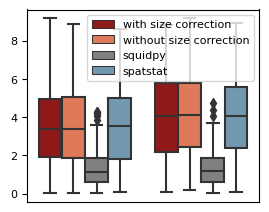

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
# plt.rcParams["figure.figsize"] = [4.00, 3.50]
# plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 8})
fig = plt.figure()
fig.set_size_inches(3, 2.5)

spatstat = pd.read_csv("spatstat1.csv")
spatstat.drop(columns=spatstat.columns[0], axis=1, inplace=True)
spatstat.columns=["cell1 vs. cell1","cell1 vs. cell2","cell2 vs. cell1","cell2 vs. cell2"]
method = ["cell1 vs. cell1","cell1 vs. cell2"]*400
kmm = with_size1["cell1 vs. cell1"].to_list()+with_size1["cell1 vs. cell2"].to_list()+\
without_size1["cell1 vs. cell1"].to_list()+without_size1["cell1 vs. cell2"].to_list()+\
squidpy1["cell1 vs. cell1"].to_list()+squidpy1["cell1 vs. cell2"].to_list()+\
spatstat["cell1 vs. cell1"].to_list()+spatstat["cell1 vs. cell2"].to_list()
color = ["with size correction"]*200+["without size correction"]*200+["squidpy"]*200+["spatstat"]*200
pal = {"without size correction":"#f46f44", "with size correction": '#a40505', "squidpy": 'grey',"spatstat":'#669bbb'}
# Create a grouped boxplot
s = sns.boxplot(x=method, y=kmm, hue=color, palette=pal)
s.set(xticklabels=[])
s.tick_params(bottom=False) 
plt.savefig("bm_box1.svg")
plt.show()

In [52]:
# benchmark2 : group distribute, without large cell
import random
spatial = pd.DataFrame()
with_size2 = pd.DataFrame(index=range(0,100),columns=['cell1 vs. cell1','cell1 vs. cell2','cell2 vs. cell1','cell2 vs. cell2'])
without_size2 = pd.DataFrame(index=range(0,100),columns=['cell1 vs. cell1','cell1 vs. cell2','cell2 vs. cell1','cell2 vs. cell2'])
squidpy2 = pd.DataFrame(index=range(0,100),columns=['cell1 vs. cell1','cell1 vs. cell2','cell2 vs. cell1','cell2 vs. cell2'])
for s in range(0,100,1):
    random.seed(s)
    xrange = [0,330]
    yrange = [0,330]
    W = window(xrange,yrange)
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    for i in range(0,50):
        n = random.randint(0, 200)
        x1.append(n)
        n = random.randint(0, 200)
        y1.append(n)
        n = random.randint(150, 330)
        x2.append(n)
        n = random.randint(150, 330)
        y2.append(n)
    mark1 = []
    mark2 = []
    for i in range(0,50):
        n = random.randint(1,5)
        mark1.append(1)
        n = random.randint(1,5)
        mark2.append(2)
    x=x1+x2
    y=y1+y2
    d = [3]*len(x)
    
    mark_1 = mark1+[0]*len(mark2)
    mark_2 = [0]*len(mark1)+mark2
    mark = pd.DataFrame()
    mark["cell1"] = mark_1
    mark["cell2"] = mark_2
    
    new_spat = pd.DataFrame([x,y,mark_1,mark_2])
    spatial = pd.concat([spatial,new_spat.transpose()])
    # with size considered 
    p = pointPattern(x,y,d,W,mark)
    r, funs = markcorr.markcorr(p, saveImage=False,savefolder = "./", remove_zeros=False)
    iso, trans = {}, {}
    for i in funs:
        trans[i] = (funs[i][0])
        iso[i] = (funs[i][1])
    trans = pd.DataFrame(trans)
    trans["r"] = r
    for col in trans:
        if col == 'r':
            continue
        v = trans[col]
        
        # plt.plot(trans.r, v)
        # plt.show()
        v = (v - v.min()) / (v.max() - v.min())
        near_y = v[trans.r<10]
        near_x = trans.r[trans.r<10]
        auc_near = np.trapz(y=list(near_y), x=list(near_x))
        far_y = v[(trans.r<160) & (trans.r>=150)]
        far_x = trans.r[(trans.r<160) & (trans.r>=150)]
        auc_far = np.trapz(y=list(far_y), x=list(far_x))
        sizecorr_diff = abs(auc_near-auc_far)
        with_size2[col][s] = sizecorr_diff

    # without size considered 
    d=None
    p = pointPattern(x,y,d,W,mark)
    r, funs = markcorr.markcorr(p, saveImage=False,savefolder = "./", remove_zeros=False)

    iso, trans = {}, {}
    for i in funs:
        trans[i] = (funs[i][0])
        iso[i] = (funs[i][1])
    trans = pd.DataFrame(trans)
    trans["r"] = r
    for col in trans:
        if col == 'r':
            continue
        v = trans[col]
        v = (v - v.min()) / (v.max() - v.min())
        near_y = v[trans.r<10]
        near_x = trans.r[trans.r<10]
        auc_near = np.trapz(y=list(near_y), x=list(near_x))
        far_y = v[(trans.r<160) & (trans.r>=150)]
        far_x = trans.r[(trans.r<160) & (trans.r>=150)]
        auc_far = np.trapz(y=list(far_y), x=list(far_x))
        sizecorr_diff = abs(auc_near-auc_far)
        without_size2[col][s] = sizecorr_diff

    # Squidpy
    spatial_squidpy = []
    for i in range(len(x1)):
        spatial_squidpy.append([x1[i],y1[i]])
    for i in range(len(x2)):
        spatial_squidpy.append([x2[i],y2[i]])
    # for i in range(len(adipocyte_x)):
    #     spatial.append([adipocyte_x[i],adipocyte_y[i]])
    cell_type_colors = ["#c82423","#3B5284"]

    cell_type = ["cell1"]*len(x1)+["cell2"]*len(x2)
    cell_type=pd.DataFrame(cell_type,columns =['cell_type'])
    spatial_squidpy=np.array(spatial_squidpy)

    counts = csr_matrix(np.random.poisson(1, size=(len(x1)+len(x2),10)), dtype=np.float32)
    adata = anndata.AnnData(counts)
    adata.obs = cell_type.astype('category')
    adata.uns = {"cell_type_colors":cell_type_colors}
    adata.obsm["spatial"] = spatial_squidpy
    interval_near = np.linspace(0, 10, 50)
    sq.gr.co_occurrence(adata, cluster_key="cell_type",interval=interval_near)
    out_near = co_occurrence(
        adata,
        cluster_key="cell_type",
        clusters=["cell1", "cell2"]
    )
    interval_far = np.linspace(150, 160, 50)
    sq.gr.co_occurrence(adata, cluster_key="cell_type",interval=interval_far)
    out_far = co_occurrence(
        adata,
        cluster_key="cell_type",
        clusters=["cell1", "cell2"]
    )
    squidpy2.loc[s] = abs(np.array(out_near)-np.array(out_far))

/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
100%|██████████| 1/1 [00:00<00:00,  6.05/s]
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/tmp/ipykernel_16890/2205381807.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["probability"][0]=0
/tmp/ipykernel_16890/2205381807.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version

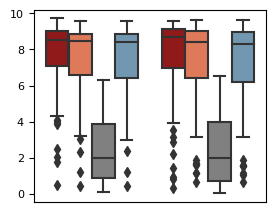

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
# plt.rcParams["figure.figsize"] = [4.00, 3.50]
# plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 8})
fig = plt.figure()
fig.set_size_inches(3, 2.5)

spatstat2 = pd.read_csv("spatstat2.csv")
spatstat2.drop(columns=spatstat2.columns[0], axis=1, inplace=True)
spatstat2.columns=["cell1 vs. cell1","cell1 vs. cell2","cell2 vs. cell1","cell2 vs. cell2"]
method = ["cell1 vs. cell1","cell1 vs. cell2"]*400
kmm = with_size2["cell1 vs. cell1"].to_list()+with_size2["cell1 vs. cell2"].to_list()+\
without_size2["cell1 vs. cell1"].to_list()+without_size2["cell1 vs. cell2"].to_list()+\
squidpy2["cell1 vs. cell1"].to_list()+squidpy2["cell1 vs. cell2"].to_list()+\
spatstat2["cell1 vs. cell1"].to_list()+spatstat2["cell1 vs. cell2"].to_list()
color = ["with size correction"]*200+["without size correction"]*200+["squidpy"]*200+["spatstat"]*200
pal = {"without size correction":"#f46f44", "with size correction": '#a40505', "squidpy": 'grey',"spatstat":'#669bbb'}
# Create a grouped boxplot
s = sns.boxplot(x=method, y=kmm, hue=color, palette=pal)
s.set(xticklabels=[])
s.legend_.remove()
s.tick_params(bottom=False) 
plt.savefig("bm_box2.svg")
plt.show()

In [74]:
# benchmark3 : group distribute, with large cell
import random
spatial = pd.DataFrame()
with_size3 = pd.DataFrame(index=range(0,100),columns=['cell1 vs. cell1','cell1 vs. cell2','cell2 vs. cell1','cell2 vs. cell2'])
without_size3 = pd.DataFrame(index=range(0,100),columns=['cell1 vs. cell1','cell1 vs. cell2','cell2 vs. cell1','cell2 vs. cell2'])
squidpy3 = pd.DataFrame(index=range(0,100),columns=['cell1 vs. cell1','cell1 vs. cell2','cell2 vs. cell1','cell2 vs. cell2'])
for s in range(0,100,1):
    random.seed(s)
    xrange = [0,330]
    yrange = [0,330]
    W = window(xrange,yrange)
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    for i in range(0,50):
        n = random.randint(0, 330)
        x1.append(n)
        n = random.randint(0, 330)
        y1.append(n)
    for i in range(0,50):
        n = random.randint(0, 330)
        x2.append(n)
        n = random.randint(0, 330)
        y2.append(n)
    mark1 = []
    mark2 = []
    mark3 = []
    for i in range(0,50):
        n = random.randint(1,5)
        mark1.append(1)
        n = random.randint(1,5)
        mark2.append(2)

    d1 = [3]*len(x1)
    # adipocyte_x = [35,110,30,150,200,230,280,80,30,200,300,130,270,180]
    # adipocyte_y = [27,60,100,150,300,220,50,190,260,80,280,230,130,0]
    adipocyte_x = [35,110,30,150,200,230,280,80,30]
    adipocyte_y = [27,60,100,150,300,220,50,190,260]
    rm_idx = []
    for i in range(len(x1)):
        for j in range(len(adipocyte_x)):
            d2_0 = (x1[i]-adipocyte_x[j])**2 + (y1[i]-adipocyte_y[j])**2
            if d2_0 < 1681:
                rm_idx.append(i)
    x1 = np.delete(x1,rm_idx).tolist()
    y1 = np.delete(y1,rm_idx).tolist()
    mark1 = np.delete(mark1,rm_idx).tolist()
    d1 = np.delete(d1,rm_idx).tolist()
    
    d2 = [3]*len(x2)
    rm_idx = []
    for i in range(len(x2)):
        for j in range(len(adipocyte_x)):
            d2_0 = (x2[i]-adipocyte_x[j])**2 + (y2[i]-adipocyte_y[j])**2
            if d2_0 < 1681:
                rm_idx.append(i)
    x2 = np.delete(x2,rm_idx).tolist()
    y2 = np.delete(y2,rm_idx).tolist()
    mark2 = np.delete(mark2,rm_idx).tolist()
    d2 = np.delete(d2,rm_idx).tolist()

    x=x1+x2
    y=y1+y2
    d=d1+d2
    for i in range(len(adipocyte_x)):
        n = random.randint(1,5)
        mark3.append(3)

    mark_1 = mark1+[0]*len(mark2)
    mark_2 = [0]*len(mark1)+mark2
    mark = pd.DataFrame()
    mark["cell1"] = mark_1
    mark["cell2"] = mark_2
    
    # with size considered 
    p = pointPattern(x,y,d,W,mark)
    p_adipo = pointPattern(adipocyte_x,adipocyte_y,[80]*len(adipocyte_x),W,mark3)
    r, funs = markcorr.markcorr(p, pp=p_adipo,saveImage=False,savefolder = "./", remove_zeros=False)
    iso, trans = {}, {}
    for i in funs:
        trans[i] = (funs[i][0])
    trans = pd.DataFrame(trans)
    trans["r"] = r
    for col in trans:
        if col not in with_size3:
            continue
        v = trans[col]
        v = (v - v.min()) / (v.max() - v.min())
        near_y = v[trans.r<10]
        near_x = trans.r[trans.r<10]
        auc_near = np.trapz(y=list(near_y), x=list(near_x))
        far_y = v[(trans.r<160) & (trans.r>=150)]
        far_x = trans.r[(trans.r<160) & (trans.r>=150)]
        auc_far = np.trapz(y=list(far_y), x=list(far_x))
        sizecorr_diff = abs(auc_near-auc_far)
        with_size3[col][s] = sizecorr_diff

    # without size considered 
    d=None
    p = pointPattern(x,y,d,W,mark)
    r, funs = markcorr.markcorr(p, saveImage=False,savefolder = "./", remove_zeros=False)

    iso, trans = {}, {}
    for i in funs:
        trans[i] = (funs[i][0])
        iso[i] = (funs[i][1])
    trans = pd.DataFrame(trans)
    trans["r"] = r
    for col in trans:
        if col not in without_size3:
            continue
        v = trans[col]
        v = (v - v.min()) / (v.max() - v.min())
        near_y = v[trans.r<10]
        near_x = trans.r[trans.r<10]
        auc_near = np.trapz(y=list(near_y), x=list(near_x))
        far_y = v[(trans.r<160) & (trans.r>=150)]
        far_x = trans.r[(trans.r<160) & (trans.r>=150)]
        auc_far = np.trapz(y=list(far_y), x=list(far_x))
        sizecorr_diff = abs(auc_near-auc_far)
        without_size3[col][s] = sizecorr_diff
        
    # Squidpy
    spatial = []
    for i in range(len(x1)):
        spatial.append([x1[i],y1[i]])
    for i in range(len(x2)):
        spatial.append([x2[i],y2[i]])
    cell_type_colors = ["#c82423","#3B5284"]

    cell_type = ["cell1"]*len(x1)+["cell2"]*len(x2)
    cell_type=pd.DataFrame(cell_type,columns =['cell_type'])
    spatial=np.array(spatial)

    counts = csr_matrix(np.random.poisson(1, size=(len(x1)+len(x2),10)), dtype=np.float32)
    adata = anndata.AnnData(counts)
    adata.obs = cell_type.astype('category')
    adata.uns = {"cell_type_colors":cell_type_colors}
    adata.obsm["spatial"] = spatial
    interval_near = np.linspace(0, 10, 50)
    sq.gr.co_occurrence(adata, cluster_key="cell_type",interval=interval_near)
    out_near = co_occurrence(
        adata,
        cluster_key="cell_type",
        clusters=["cell1", "cell2"]
    )
    interval_far = np.linspace(150, 160, 50)
    sq.gr.co_occurrence(adata, cluster_key="cell_type",interval=interval_far)
    out_far = co_occurrence(
        adata,
        cluster_key="cell_type",
        clusters=["cell1", "cell2"]
    )
    squidpy3.loc[s] = abs(np.array(out_near)-np.array(out_far))

/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
100%|██████████| 1/1 [00:00<00:00,  3.11/s]
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/tmp/ipykernel_16890/2205381807.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["probability"][0]=0
/tmp/ipykernel_16890/2205381807.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version

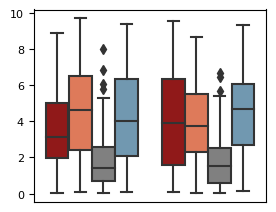

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.rcParams.update({'font.size': 8})
fig = plt.figure()
fig.set_size_inches(3, 2.5)

spatstat3 = pd.read_csv("spatstat3.csv")
spatstat3.drop(columns=spatstat3.columns[0], axis=1, inplace=True)
spatstat3.columns=["cell1 vs. cell1","cell1 vs. cell2","cell2 vs. cell1","cell2 vs. cell2"]
method = ["cell1 vs. cell1","cell1 vs. cell2"]*400
kmm = with_size3["cell1 vs. cell1"].to_list()+with_size3["cell1 vs. cell2"].to_list()+\
without_size3["cell1 vs. cell1"].to_list()+without_size3["cell1 vs. cell2"].to_list()+\
squidpy3["cell1 vs. cell1"].to_list()+squidpy3["cell1 vs. cell2"].to_list()+\
spatstat3["cell1 vs. cell1"].to_list()+spatstat3["cell1 vs. cell2"].to_list()
color = ["with size correction"]*200+["without size correction"]*200+["squidpy"]*200+["spatstat"]*200
pal = {"without size correction":"#f46f44", "with size correction": '#a40505', "squidpy": 'grey',"spatstat":'#669bbb'}
# Create a grouped boxplot
s = sns.boxplot(x=method, y=kmm, hue=color, palette=pal)
s.set(xticklabels=[])
s.legend_.remove()
s.tick_params(bottom=False) 
plt.savefig("bm_box3.svg")
plt.show()

In [56]:
# benchmark4 : group distribute, with large cell
import random
spatial = pd.DataFrame(index=range(0,100),columns=['x','y','mark1','mark2','mark3'])
with_size4 = pd.DataFrame(index=range(0,100),columns=['cell1 vs. cell1','cell1 vs. cell2','cell2 vs. cell1','cell2 vs. cell2'])
without_size4 = pd.DataFrame(index=range(0,100),columns=['cell1 vs. cell1','cell1 vs. cell2','cell2 vs. cell1','cell2 vs. cell2'])
squidpy4 = pd.DataFrame(index=range(0,100),columns=['cell1 vs. cell1','cell1 vs. cell2','cell2 vs. cell1','cell2 vs. cell2'])
for s in range(0,100,1):
    random.seed(s)
    xrange = [0,330]
    yrange = [0,330]
    W = window(xrange,yrange)
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    for i in range(0,50):
        n = random.randint(0, 200)
        x1.append(n)
        n = random.randint(0, 200)
        y1.append(n)
        n = random.randint(150, 330)
        x2.append(n)
        n = random.randint(150, 330)
        y2.append(n)
    mark1 = []
    mark2 = []
    mark3 = []
    for i in range(0,50):
        n = random.randint(1,5)
        mark1.append(n)
        n = random.randint(1,5)
        mark2.append(n)

    d1 = [3]*len(x1)
    adipocyte_x = [35,110,30,150,200,230,280,80,30,200,300,130,270,180]
    adipocyte_y = [27,60,100,150,300,220,50,190,260,80,280,230,130,0]
    rm_idx = []
    for i in range(len(x1)):
        for j in range(len(adipocyte_x)):
            d2_0 = (x1[i]-adipocyte_x[j])**2 + (y1[i]-adipocyte_y[j])**2
            if d2_0 < 1681:
                rm_idx.append(i)
    x1 = np.delete(x1,rm_idx).tolist()
    y1 = np.delete(y1,rm_idx).tolist()
    mark1 = np.delete(mark1,rm_idx).tolist()
    d1 = np.delete(d1,rm_idx).tolist()
    
    d2 = [3]*len(x2)
    rm_idx = []
    for i in range(len(x2)):
        for j in range(len(adipocyte_x)):
            d2_0 = (x2[i]-adipocyte_x[j])**2 + (y2[i]-adipocyte_y[j])**2
            if d2_0 < 1681:
                rm_idx.append(i)
    x2 = np.delete(x2,rm_idx).tolist()
    y2 = np.delete(y2,rm_idx).tolist()
    mark2 = np.delete(mark2,rm_idx).tolist()
    d2 = np.delete(d2,rm_idx).tolist()

    x=x1+x2
    y=y1+y2
    d=d1+d2
    for i in range(len(adipocyte_x)):
        n = random.randint(1,5)
        mark3.append(3)

    mark_1 = mark1+[0]*len(mark2)
    mark_2 = [0]*len(mark1)+mark2
    mark = pd.DataFrame()
    mark["cell1"] = mark_1
    mark["cell2"] = mark_2
    
    # with size considered 
    p = pointPattern(x,y,d,W,mark)
    p_adipo = pointPattern(adipocyte_x,adipocyte_y,[80]*len(adipocyte_x),W,mark3)
    r, funs = markcorr.markcorr(p, pp=p_adipo,saveImage=False,savefolder = "./", remove_zeros=False)
    iso, trans = {}, {}
    for i in funs:
        trans[i] = (funs[i][0])
        iso[i] = (funs[i][1])
    trans = pd.DataFrame(trans)
    trans["r"] = r
    for col in trans:
        if col not in with_size4:
            continue
        v = trans[col]
        v = (v - v.min()) / (v.max() - v.min())
        near_y = v[trans.r<10]
        near_x = trans.r[trans.r<10]
        auc_near = np.trapz(y=list(near_y), x=list(near_x))
        far_y = v[(trans.r<160) & (trans.r>=150)]
        far_x = trans.r[(trans.r<160) & (trans.r>=150)]
        auc_far = np.trapz(y=list(far_y), x=list(far_x))
        sizecorr_diff = abs(auc_near-auc_far)
        with_size4[col][s] = sizecorr_diff

    # without size considered 
    d=None
    mark_1 = mark1+[0]*len(mark2)+[0]*len(mark3)
    mark_2 = [0]*len(mark1)+mark2+[0]*len(mark3)
    mark_3 = [0]*len(mark1)+[0]*len(mark2)+mark3
    mark = pd.DataFrame()
    mark["cell1"] = mark_1
    mark["cell2"] = mark_2
    mark["largecell"] = mark_3
    x = x+adipocyte_x
    y = y+adipocyte_y
    p = pointPattern(x,y,d,W,mark)
    r, funs = markcorr.markcorr(p, saveImage=False,savefolder = "./", remove_zeros=False)

    iso, trans = {}, {}
    for i in funs:
        trans[i] = (funs[i][0])
        iso[i] = (funs[i][1])
    trans = pd.DataFrame(trans)
    trans["r"] = r
    for col in trans:
        if col not in without_size4:
            continue
        v = trans[col]
        v = (v - v.min()) / (v.max() - v.min())
        near_y = v[trans.r<10]
        near_x = trans.r[trans.r<10]
        auc_near = np.trapz(y=list(near_y), x=list(near_x))
        far_y = v[(trans.r<160) & (trans.r>=150)]
        far_x = trans.r[(trans.r<160) & (trans.r>=150)]
        auc_far = np.trapz(y=list(far_y), x=list(far_x))
        sizecorr_diff = abs(auc_near-auc_far)
        without_size4[col][s] = sizecorr_diff

    # Squidpy
    spatial = []
    for i in range(len(x1)):
        spatial.append([x1[i],y1[i]])
    for i in range(len(x2)):
        spatial.append([x2[i],y2[i]])
    cell_type_colors = ["#c82423","#3B5284"]

    cell_type = ["cell1"]*len(x1)+["cell2"]*len(x2)
    cell_type=pd.DataFrame(cell_type,columns =['cell_type'])
    spatial=np.array(spatial)

    counts = csr_matrix(np.random.poisson(1, size=(len(x1)+len(x2),10)), dtype=np.float32)
    adata = anndata.AnnData(counts)
    adata.obs = cell_type.astype('category')
    adata.uns = {"cell_type_colors":cell_type_colors}
    adata.obsm["spatial"] = spatial
    interval_near = np.linspace(0, 10, 50)
    sq.gr.co_occurrence(adata, cluster_key="cell_type",interval=interval_near)
    out_near = co_occurrence(
        adata,
        cluster_key="cell_type",
        clusters=["cell1", "cell2"]
    )
    interval_far = np.linspace(150, 160, 50)
    sq.gr.co_occurrence(adata, cluster_key="cell_type",interval=interval_far)
    out_far = co_occurrence(
        adata,
        cluster_key="cell_type",
        clusters=["cell1", "cell2"]
    )
    squidpy4.loc[s] = abs(np.array(out_near)-np.array(out_far))

/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
100%|██████████| 1/1 [00:00<00:00,  3.10/s]
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/tmp/ipykernel_16890/2205381807.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["probability"][0]=0
/tmp/ipykernel_16890/2205381807.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version

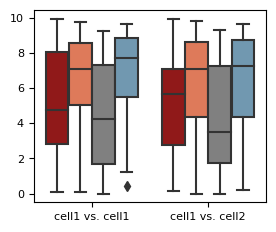

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
# plt.rcParams["figure.figsize"] = [4.00, 3.50]
# plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 8})
fig = plt.figure()
fig.set_size_inches(3, 2.5)

spatstat4 = pd.read_csv("spatstat4.csv")
spatstat4.drop(columns=spatstat4.columns[0], axis=1, inplace=True)
spatstat4.columns=["cell1 vs. cell1","cell1 vs. cell2","cell2 vs. cell1","cell2 vs. cell2"]
method = ["cell1 vs. cell1","cell1 vs. cell2"]*400
kmm = with_size4["cell1 vs. cell1"].to_list()+with_size4["cell1 vs. cell2"].to_list()+\
without_size4["cell1 vs. cell1"].to_list()+without_size4["cell1 vs. cell2"].to_list()+\
squidpy4["cell1 vs. cell1"].to_list()+squidpy4["cell1 vs. cell2"].to_list()+\
spatstat4["cell1 vs. cell1"].to_list()+spatstat4["cell1 vs. cell2"].to_list()
color = ["with size correction"]*200+["without size correction"]*200+["squidpy"]*200+["spatstat"]*200
pal = {"without size correction":"#f46f44", "with size correction": '#a40505', "squidpy": 'grey',"spatstat":'#669bbb'}
# Create a grouped boxplot
s = sns.boxplot(x=method, y=kmm, hue=color, palette=pal)
s.legend_.remove()
plt.savefig("bm_box4.svg")
plt.show()

/tmp/ipykernel_16890/3503108995.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  without_adipo_med = [with_size1.median()[0],without_size1.median()[0],squidpy1.median()[0],spatstat.median()[0]]
/tmp/ipykernel_16890/3503108995.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  without_adipo_med = [with_size1.median()[0],without_size1.median()[0],squidpy1.median()[0],spatstat.median()[0]]
/tmp/ipykernel_16890/3503108995.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

<Figure size 400x350 with 0 Axes>

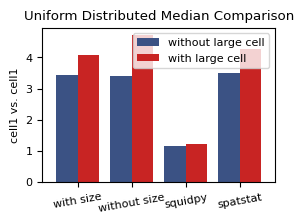

In [101]:
# Uniform plot
plt.rcParams.update({'font.size': 8})
fig = plt.figure()
fig.set_size_inches(4, 3.5)
without_adipo_med = [with_size1.median()[0],without_size1.median()[0],squidpy1.median()[0],spatstat.median()[0]]
with_adipo_med = [with_size3.median()[0],without_size3.median()[0],squidpy3.median()[0],spatstat3.median()[0]]
uniform_df = pd.DataFrame({"method": ["with size","without size","squidpy","spatstat"], "without large cell":without_adipo_med,"with large cell":with_adipo_med})
uniform_df.plot(x="method", y=["without large cell", "with large cell"], kind="bar",figsize=(3, 2), color=["#3B5284","#c82423"],width=0.8) 
# uniform_df1 = pd.DataFrame({"method": ["with size","without size","squidpy","spatstat"]*2, "large cell":without_adipo_med+with_adipo_med,"type":["without_adipo_med","with_adipo_med"]*4})
# uniform_df1=uniform_df1.astype({'large cell': 'int32'})
# sns.barplot(data=uniform_df1,x="method",y="large cell",hue="type")
plt.xticks(rotation=10)
plt.xlabel(None)
plt.ylabel("cell1 vs. cell1")
plt.title("Uniform Distributed Median Comparison")
plt.savefig("uniform.svg")
plt.show()

/tmp/ipykernel_16890/30239429.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  without_adipo_med = [with_size2.median()[0],without_size2.median()[0],squidpy2.median()[0],spatstat2.median()[0]]
/tmp/ipykernel_16890/30239429.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  without_adipo_med = [with_size2.median()[0],without_size2.median()[0],squidpy2.median()[0],spatstat2.median()[0]]
/tmp/ipykernel_16890/30239429.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a val

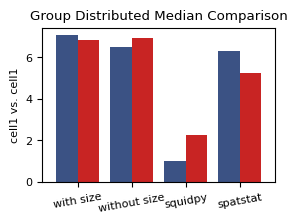

In [106]:
# Group plot
without_adipo_med = [with_size2.median()[0],without_size2.median()[0],squidpy2.median()[0],spatstat2.median()[0]]
with_adipo_med = [with_size4.median()[0],without_size4.median()[0],squidpy4.median()[0],spatstat4.median()[0]]
group_df = pd.DataFrame({"method": ["with size","without size","squidpy","spatstat"], "without large cell":without_adipo_med,"with large cell":with_adipo_med})
p = group_df.plot(x="method", y=["without large cell", "with large cell"], kind="bar",figsize=(3, 2), color=["#3B5284","#c82423"],width=0.8)
plt.xticks(rotation=10)
plt.xlabel(None)
plt.ylabel("cell1 vs. cell1")
p.get_legend().remove()
plt.title("Group Distributed Median Comparison")
plt.savefig("group.svg")

/tmp/ipykernel_16890/3714816339.py:26: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(case1_med[0])
/tmp/ipykernel_16890/3714816339.py:74: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(case1_med[1])
/tmp/ipykernel_16890/3714816339.py:123: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(case1_med[2])
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinsta

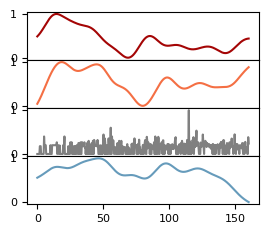

In [116]:
import matplotlib.pyplot as plt
import random
from matplotlib.gridspec import GridSpec
case1_with_size_med = with_size1.loc[with_size1['cell1 vs. cell1']==with_size1['cell1 vs. cell1'][0:99].median()].index[0]
case1_without_size_med = without_size1.loc[without_size1['cell1 vs. cell1']==without_size1['cell1 vs. cell1'][0:99].median()].index[0]
case1_squidpy_med = squidpy1.loc[squidpy1['cell1 vs. cell1']==squidpy1['cell1 vs. cell1'][0:99].median()].index[0]
case1_spatstat_med = spatstat.loc[spatstat['cell1 vs. cell1']==spatstat['cell1 vs. cell1'][0:99].median()].index[0]
case1_med = [case1_with_size_med,case1_without_size_med,case1_squidpy_med,case1_spatstat_med]
case1_med
# Create a figure and a GridSpec object
plt.rcParams.update({'font.size': 8})
fig = plt.figure()
fig.set_size_inches(3, 2.5)
gs = GridSpec(4, 1, hspace=0, wspace=0)

# Create subplots using the GridSpec object
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[3, 0])

xrange = [0,330]
yrange = [0,330]
W = window(xrange,yrange)
# with size considered
random.seed(case1_med[0])
x1 = []
y1 = []
x2 = []
y2 = []
for i in range(0,50):
    n = random.randint(0, 330)
    x1.append(n)
    n = random.randint(0, 330)
    y1.append(n)
    n = random.randint(0, 330)
    x2.append(n)
    n = random.randint(0, 330)
    y2.append(n)
x=x1+x2
y=y1+y2
mark1 = []
mark2 = []
for i in range(0,50):
    n = random.randint(1,5)
    mark1.append(1)
    n = random.randint(1,5)
    mark2.append(2)
d = [3]*len(x)

mark_1 = mark1+[0]*len(mark2)
mark_2 = [0]*len(mark1)+mark2
mark = pd.DataFrame()
mark["cell1"] = mark_1
mark["cell2"] = mark_2
p = pointPattern(x,y,d,W,mark)
r, funs = markcorr.markcorr(p, saveImage=False,savefolder = "./", remove_zeros=False, plot=False)
iso, trans = {}, {}
for i in funs:
    trans[i] = (funs[i][0])
    iso[i] = (funs[i][1])
trans = pd.DataFrame(trans)
trans["r"] = r
for col in trans:
    if col == 'r':
        continue
    v = trans[col]
    v = (v - v.min()) / (v.max() - v.min())
    x = trans.r[trans.r<160].to_list()
    y = v[trans.r<160].to_list()
    ax1.plot(x, y,color="#a40505")
    break
# without size considered
random.seed(case1_med[1])
x1 = []
y1 = []
x2 = []
y2 = []
for i in range(0,50):
    n = random.randint(0, 330)
    x1.append(n)
    n = random.randint(0, 330)
    y1.append(n)
    n = random.randint(0, 330)
    x2.append(n)
    n = random.randint(0, 330)
    y2.append(n)
x=x1+x2
y=y1+y2
mark1 = []
mark2 = []
for i in range(0,50):
    n = random.randint(1,5)
    mark1.append(1)
    n = random.randint(1,5)
    mark2.append(2)
d = None

mark_1 = mark1+[0]*len(mark2)
mark_2 = [0]*len(mark1)+mark2
mark = pd.DataFrame()
mark["cell1"] = mark_1
mark["cell2"] = mark_2
p = pointPattern(x,y,d,W,mark)
r, funs = markcorr.markcorr(p, saveImage=False,savefolder = "./", remove_zeros=False, plot=False)
iso, trans = {}, {}
for i in funs:
    trans[i] = (funs[i][0])
    iso[i] = (funs[i][1])
trans = pd.DataFrame(trans)
trans["r"] = r
for col in trans:
    if col == 'r':
        continue
    v = trans[col]
    v = (v - v.min()) / (v.max() - v.min())
    x = trans.r[trans.r<160].to_list()
    y = v[trans.r<160].to_list()
    ax2.plot(x, y,color="#f46f44")
    break  

# Squidpy
random.seed(case1_med[2])
x1 = []
y1 = []
x2 = []
y2 = []
for i in range(0,50):
    n = random.randint(0, 330)
    x1.append(n)
    n = random.randint(0, 330)
    y1.append(n)
    n = random.randint(0, 330)
    x2.append(n)
    n = random.randint(0, 330)
    y2.append(n)
spatial_squidpy = []
for i in range(len(x1)):
    spatial_squidpy.append([x1[i],y1[i]])
for i in range(len(x2)):
    spatial_squidpy.append([x2[i],y2[i]])
# for i in range(len(adipocyte_x)):
#     spatial.append([adipocyte_x[i],adipocyte_y[i]])
cell_type_colors = ["#c82423","#3B5284"]

cell_type = ["cell1"]*len(x1)+["cell2"]*len(x2)
cell_type=pd.DataFrame(cell_type,columns =['cell_type'])
spatial_squidpy=np.array(spatial_squidpy)

counts = csr_matrix(np.random.poisson(1, size=(len(x1)+len(x2),10)), dtype=np.float32)
adata = anndata.AnnData(counts)
adata.obs = cell_type.astype('category')
adata.uns = {"cell_type_colors":cell_type_colors}
adata.obsm["spatial"] = spatial_squidpy
interval_far = np.linspace(0, 160, 500)
sq.gr.co_occurrence(adata, cluster_key="cell_type",interval=interval_far)
plt_squidpy = plt_co_occurrence(
        adata,
        cluster_key="cell_type",
        clusters=["cell1", "cell2"])
ax3.plot(plt_squidpy["r"], plt_squidpy["kmm"],color="grey")

# spatstat
random.seed(case1_med[3])
x1 = []
y1 = []
x2 = []
y2 = []
for i in range(0,50):
    n = random.randint(0, 330)
    x1.append(n)
    n = random.randint(0, 330)
    y1.append(n)
    n = random.randint(0, 330)
    x2.append(n)
    n = random.randint(0, 330)
    y2.append(n)
x=x1+x2
y=y1+y2
mark1 = []
mark2 = []
for i in range(0,50):
    n = random.randint(1,5)
    mark1.append(1)
    n = random.randint(1,5)
    mark2.append(2)
d = [3]*len(x)

mark_1 = mark1+[0]*len(mark2)
mark_2 = [0]*len(mark1)+mark2
mark = pd.DataFrame()
mark["cell1"] = mark_1
mark["cell2"] = mark_2
spatial = pd.DataFrame([x,y,mark_1,mark_2]).transpose()
spatial.columns=["x","y","mark1","mark2"]
spatial.to_csv("./benchmark1_med.csv")


# run spatstat on the data to get plot
spatstat_med = pd.read_csv("spatstat_med1.csv")
ax4.plot(spatstat_med["r"], spatstat_med["med1"],color="#669bbb")
plt.savefig("bm1_line.svg")

/tmp/ipykernel_16890/2821431247.py:25: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(case2_med[0])
/tmp/ipykernel_16890/2821431247.py:73: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(case2_med[1])
/tmp/ipykernel_16890/2821431247.py:122: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(case2_med[2])
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinsta

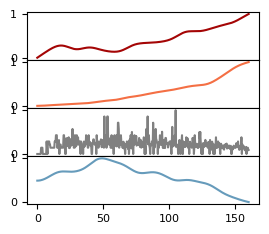

In [117]:
import matplotlib.pyplot as plt
import random
from matplotlib.gridspec import GridSpec
case2_with_size_med = with_size2.loc[with_size2['cell1 vs. cell1']==with_size2['cell1 vs. cell1'][0:99].median()].index[0]
case2_without_size_med = without_size2.loc[without_size2['cell1 vs. cell1']==without_size2['cell1 vs. cell1'][0:99].median()].index[0]
case2_squidpy_med = squidpy2.loc[squidpy2['cell1 vs. cell1']==squidpy2['cell1 vs. cell1'][0:99].median()].index[0]
case2_spatstat_med = spatstat2.loc[spatstat2['cell1 vs. cell1']==spatstat2['cell1 vs. cell1'][0:99].median()].index[0]
case2_med = [case2_with_size_med,case2_without_size_med,case2_squidpy_med,case2_spatstat_med]
# Create a figure and a GridSpec object
plt.rcParams.update({'font.size': 8})
fig = plt.figure()
fig.set_size_inches(3, 2.5)
gs = GridSpec(4, 1, hspace=0, wspace=0)

# Create subplots using the GridSpec object
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[3, 0])

xrange = [0,330]
yrange = [0,330]
W = window(xrange,yrange)
# with size considered
random.seed(case2_med[0])
x1 = []
y1 = []
x2 = []
y2 = []
for i in range(0,50):
    n = random.randint(0, 200)
    x1.append(n)
    n = random.randint(0, 200)
    y1.append(n)
    n = random.randint(150, 330)
    x2.append(n)
    n = random.randint(150, 330)
    y2.append(n)
x=x1+x2
y=y1+y2
mark1 = []
mark2 = []
for i in range(0,50):
    n = random.randint(1,5)
    mark1.append(1)
    n = random.randint(1,5)
    mark2.append(2)
d = [3]*len(x)

mark_1 = mark1+[0]*len(mark2)
mark_2 = [0]*len(mark1)+mark2
mark = pd.DataFrame()
mark["cell1"] = mark_1
mark["cell2"] = mark_2
p = pointPattern(x,y,d,W,mark)
r, funs = markcorr.markcorr(p, saveImage=False,savefolder = "./", remove_zeros=False, plot=False)
iso, trans = {}, {}
for i in funs:
    trans[i] = (funs[i][0])
    iso[i] = (funs[i][1])
trans = pd.DataFrame(trans)
trans["r"] = r
for col in trans:
    if col == 'r':
        continue
    v = trans['cell1 vs. cell2']
    v = (v - v.min()) / (v.max() - v.min())
    x = trans.r[trans.r<160].to_list()
    y = v[trans.r<160].to_list()
    ax1.plot(x, y,color="#a40505")
    break
# without size considered
random.seed(case2_med[1])
x1 = []
y1 = []
x2 = []
y2 = []
for i in range(0,50):
    n = random.randint(0, 200)
    x1.append(n)
    n = random.randint(0, 200)
    y1.append(n)
    n = random.randint(150, 330)
    x2.append(n)
    n = random.randint(150, 330)
    y2.append(n)
x=x1+x2
y=y1+y2
mark1 = []
mark2 = []
for i in range(0,50):
    n = random.randint(1,5)
    mark1.append(1)
    n = random.randint(1,5)
    mark2.append(2)
d = None

mark_1 = mark1+[0]*len(mark2)
mark_2 = [0]*len(mark1)+mark2
mark = pd.DataFrame()
mark["cell1"] = mark_1
mark["cell2"] = mark_2
p = pointPattern(x,y,d,W,mark)
r, funs = markcorr.markcorr(p, saveImage=False,savefolder = "./", remove_zeros=False, plot=False)
iso, trans = {}, {}
for i in funs:
    trans[i] = (funs[i][0])
    iso[i] = (funs[i][1])
trans = pd.DataFrame(trans)
trans["r"] = r
for col in trans:
    if col == 'r':
        continue
    v = trans['cell1 vs. cell2']
    v = (v - v.min()) / (v.max() - v.min())
    x = trans.r[trans.r<160].to_list()
    y = v[trans.r<160].to_list()
    ax2.plot(x, y,color="#f46f44")
    break  

# Squidpy
random.seed(case2_med[2])
x1 = []
y1 = []
x2 = []
y2 = []
for i in range(0,50):
    n = random.randint(0, 200)
    x1.append(n)
    n = random.randint(0, 200)
    y1.append(n)
    n = random.randint(150, 330)
    x2.append(n)
    n = random.randint(150, 330)
    y2.append(n)
spatial_squidpy = []
for i in range(len(x1)):
    spatial_squidpy.append([x1[i],y1[i]])
for i in range(len(x2)):
    spatial_squidpy.append([x2[i],y2[i]])
# for i in range(len(adipocyte_x)):
#     spatial.append([adipocyte_x[i],adipocyte_y[i]])
cell_type_colors = ["#c82423","#3B5284"]

cell_type = ["cell1"]*len(x1)+["cell2"]*len(x2)
cell_type=pd.DataFrame(cell_type,columns =['cell_type'])
spatial_squidpy=np.array(spatial_squidpy)

counts = csr_matrix(np.random.poisson(1, size=(len(x1)+len(x2),10)), dtype=np.float32)
adata = anndata.AnnData(counts)
adata.obs = cell_type.astype('category')
adata.uns = {"cell_type_colors":cell_type_colors}
adata.obsm["spatial"] = spatial_squidpy
interval_far = np.linspace(0, 160, 500)
sq.gr.co_occurrence(adata, cluster_key="cell_type",interval=interval_far)
plt_squidpy = plt_co_occurrence(
        adata,
        cluster_key="cell_type",
        clusters=["cell1", "cell2"])
ax3.plot(plt_squidpy["r"], plt_squidpy["kmm"],color="grey")

# spatstat
random.seed(case2_med[3])
x1 = []
y1 = []
x2 = []
y2 = []
for i in range(0,50):
    n = random.randint(0, 200)
    x1.append(n)
    n = random.randint(0, 200)
    y1.append(n)
    n = random.randint(150, 330)
    x2.append(n)
    n = random.randint(150, 330)
    y2.append(n)
x=x1+x2
y=y1+y2
mark1 = []
mark2 = []
for i in range(0,50):
    n = random.randint(1,5)
    mark1.append(1)
    n = random.randint(1,5)
    mark2.append(2)
d = [3]*len(x)

mark_1 = mark1+[0]*len(mark2)
mark_2 = [0]*len(mark1)+mark2
mark = pd.DataFrame()
mark["cell1"] = mark_1
mark["cell2"] = mark_2
spatial = pd.DataFrame([x,y,mark_1,mark_2]).transpose()
spatial.columns=["x","y","mark1","mark2"]
spatial.to_csv("./benchmark2_med.csv")

# run spatstat on the data to get plot
spatstat_med = pd.read_csv("spatstat_med2.csv")
ax4.plot(spatstat_med["r"], spatstat_med["med2"],color="#669bbb")
plt.savefig("bm2_line.svg")

/tmp/ipykernel_16890/1822343634.py:25: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(case3_med[0])
/tmp/ipykernel_16890/1822343634.py:96: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(case3_med[1])
/tmp/ipykernel_16890/1822343634.py:168: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(case3_med[2])
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinsta

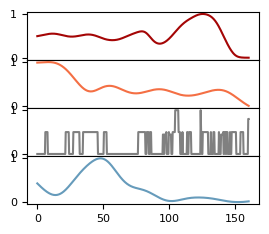

In [125]:
import matplotlib.pyplot as plt
import random
from matplotlib.gridspec import GridSpec
case3_with_size_med = with_size3.loc[with_size3['cell1 vs. cell1']==with_size3['cell1 vs. cell1'].median()].index[0]
case3_without_size_med = without_size3.loc[without_size3['cell1 vs. cell1']==without_size3['cell1 vs. cell1'][0:99].median()].index[0]
case3_squidpy_med = squidpy3.loc[squidpy3['cell1 vs. cell1']==squidpy3['cell1 vs. cell1'][0:99].median()].index[0]
case3_spatstat_med = spatstat3.loc[spatstat3['cell1 vs. cell1']==spatstat3['cell1 vs. cell1'][0:99].median()].index[0]
case3_med = [case3_with_size_med,case3_without_size_med,case3_squidpy_med,case3_spatstat_med]
# Create a figure and a GridSpec object
plt.rcParams.update({'font.size': 8})
fig = plt.figure()
fig.set_size_inches(3, 2.5)
gs = GridSpec(4, 1, hspace=0, wspace=0)

# Create subplots using the GridSpec object
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[3, 0])

xrange = [0,330]
yrange = [0,330]
W = window(xrange,yrange)
# with size considered
random.seed(case3_med[0])
x1 = []
y1 = []
x2 = []
y2 = []
for i in range(0,50):
    n = random.randint(0, 330)
    x1.append(n)
    n = random.randint(0, 330)
    y1.append(n)
    n = random.randint(0, 330)
    x2.append(n)
    n = random.randint(0, 330)
    y2.append(n)
mark1 = []
mark2 = []
for i in range(0,50):
    n = random.randint(1,5)
    mark1.append(1)
    n = random.randint(1,5)
    mark2.append(2)
d1 = [3]*len(x1)
adipocyte_x = [35,110,30,150,200,230,280,80,30,200,300,130,270,180]
adipocyte_y = [27,60,100,150,300,220,50,190,260,80,280,230,130,0]
rm_idx = []
for i in range(len(x1)):
    for j in range(len(adipocyte_x)):
        d2_0 = (x1[i]-adipocyte_x[j])**2 + (y1[i]-adipocyte_y[j])**2
        if d2_0 < 1681:
            rm_idx.append(i)
x1 = np.delete(x1,rm_idx).tolist()
y1 = np.delete(y1,rm_idx).tolist()
mark1 = np.delete(mark1,rm_idx).tolist()
d1 = np.delete(d1,rm_idx).tolist()

d2 = [3]*len(x2)
rm_idx = []
for i in range(len(x2)):
    for j in range(len(adipocyte_x)):
        d2_0 = (x2[i]-adipocyte_x[j])**2 + (y2[i]-adipocyte_y[j])**2
        if d2_0 < 1681:
            rm_idx.append(i)
x2 = np.delete(x2,rm_idx).tolist()
y2 = np.delete(y2,rm_idx).tolist()
mark2 = np.delete(mark2,rm_idx).tolist()
d2 = np.delete(d2,rm_idx).tolist()

x=x1+x2
y=y1+y2
d=d1+d2
mark_1 = mark1+[0]*len(mark2)
mark_2 = [0]*len(mark1)+mark2
mark = pd.DataFrame()
mark["cell1"] = mark_1
mark["cell2"] = mark_2

p = pointPattern(x,y,d,W,mark)    
p_adipo = pointPattern(adipocyte_x,adipocyte_y,[80]*len(adipocyte_x),W,mark3)
r, funs = markcorr.markcorr(p, pp=p_adipo,saveImage=False,savefolder = "./", remove_zeros=False, plot=False)
iso, trans = {}, {}
for i in funs:
    trans[i] = (funs[i][0])
trans = pd.DataFrame(trans)
trans["r"] = r
v = trans['cell1 vs. cell2']
v = (v - v.min()) / (v.max() - v.min())
x = trans.r[trans.r<160].to_list()
y = v[trans.r<160].to_list()
ax1.plot(x, y,color="#a40505")

# without size considered
random.seed(case3_med[1])
x1 = []
y1 = []
x2 = []
y2 = []
for i in range(0,50):
    n = random.randint(0, 330)
    x1.append(n)
    n = random.randint(0, 330)
    y1.append(n)
    n = random.randint(0, 330)
    x2.append(n)
    n = random.randint(0, 330)
    y2.append(n)
mark1 = []
mark2 = []
for i in range(0,50):
    n = random.randint(1,5)
    mark1.append(1)
    n = random.randint(1,5)
    mark2.append(2)
d1 = [3]*len(x1)
adipocyte_x = [35,110,30,150,200,230,280,80,30,200,300,130,270,180]
adipocyte_y = [27,60,100,150,300,220,50,190,260,80,280,230,130,0]
rm_idx = []
for i in range(len(x1)):
    for j in range(len(adipocyte_x)):
        d2_0 = (x1[i]-adipocyte_x[j])**2 + (y1[i]-adipocyte_y[j])**2
        if d2_0 < 1681:
            rm_idx.append(i)
x1 = np.delete(x1,rm_idx).tolist()
y1 = np.delete(y1,rm_idx).tolist()
mark1 = np.delete(mark1,rm_idx).tolist()
d1 = np.delete(d1,rm_idx).tolist()

d2 = [3]*len(x2)
rm_idx = []
for i in range(len(x2)):
    for j in range(len(adipocyte_x)):
        d2_0 = (x2[i]-adipocyte_x[j])**2 + (y2[i]-adipocyte_y[j])**2
        if d2_0 < 1681:
            rm_idx.append(i)
x2 = np.delete(x2,rm_idx).tolist()
y2 = np.delete(y2,rm_idx).tolist()
mark2 = np.delete(mark2,rm_idx).tolist()
d2 = np.delete(d2,rm_idx).tolist()

x=x1+x2
y=y1+y2
d=d1+d2
d = None

mark_1 = mark1+[0]*len(mark2)
mark_2 = [0]*len(mark1)+mark2
mark = pd.DataFrame()
mark["cell1"] = mark_1
mark["cell2"] = mark_2
p = pointPattern(x,y,d,W,mark)
r, funs = markcorr.markcorr(p, saveImage=False,savefolder = "./", remove_zeros=False, plot=False)
iso, trans = {}, {}
for i in funs:
    trans[i] = (funs[i][0])
    iso[i] = (funs[i][1])
trans = pd.DataFrame(trans)
trans["r"] = r
v = trans['cell1 vs. cell2']
v = (v - v.min()) / (v.max() - v.min())
x = trans.r[trans.r<160].to_list()
y = v[trans.r<160].to_list()
ax2.plot(x, y,color="#f46f44")

# Squidpy
random.seed(case3_med[2])
x1 = []
y1 = []
x2 = []
y2 = []
for i in range(0,50):
    n = random.randint(0, 330)
    x1.append(n)
    n = random.randint(0, 330)
    y1.append(n)
    n = random.randint(0, 330)
    x2.append(n)
    n = random.randint(0, 330)
    y2.append(n)
mark1 = []
mark2 = []
for i in range(0,50):
    n = random.randint(1,5)
    mark1.append(1)
    n = random.randint(1,5)
    mark2.append(2)
adipocyte_x = [35,110,30,150,200,230,280,80,30,200,300,130,270,180]
adipocyte_y = [27,60,100,150,300,220,50,190,260,80,280,230,130,0]
rm_idx = []
for i in range(len(x1)):
    for j in range(len(adipocyte_x)):
        d2_0 = (x1[i]-adipocyte_x[j])**2 + (y1[i]-adipocyte_y[j])**2
        if d2_0 < 1681:
            rm_idx.append(i)
x1 = np.delete(x1,rm_idx).tolist()
y1 = np.delete(y1,rm_idx).tolist()
mark1 = np.delete(mark1,rm_idx).tolist()

rm_idx = []
for i in range(len(x2)):
    for j in range(len(adipocyte_x)):
        d2_0 = (x2[i]-adipocyte_x[j])**2 + (y2[i]-adipocyte_y[j])**2
        if d2_0 < 1681:
            rm_idx.append(i)
x2 = np.delete(x2,rm_idx).tolist()
y2 = np.delete(y2,rm_idx).tolist()
mark2 = np.delete(mark2,rm_idx).tolist()

spatial_squidpy = []
for i in range(len(x1)):
    spatial_squidpy.append([x1[i],y1[i]])
for i in range(len(x2)):
    spatial_squidpy.append([x2[i],y2[i]])
# for i in range(len(adipocyte_x)):
#     spatial.append([adipocyte_x[i],adipocyte_y[i]])
cell_type_colors = ["#c82423","#3B5284"]

cell_type = ["cell1"]*len(x1)+["cell2"]*len(x2)
cell_type=pd.DataFrame(cell_type,columns =['cell_type'])
spatial_squidpy=np.array(spatial_squidpy)

counts = csr_matrix(np.random.poisson(1, size=(len(x1)+len(x2),10)), dtype=np.float32)
adata = anndata.AnnData(counts)
adata.obs = cell_type.astype('category')
adata.uns = {"cell_type_colors":cell_type_colors}
adata.obsm["spatial"] = spatial_squidpy
interval_near = np.linspace(0, 160, 500)
sq.gr.co_occurrence(adata, cluster_key="cell_type",interval=interval_far)
plt_squidpy = plt_co_occurrence(
        adata,
        cluster_key="cell_type",
        clusters=["cell1", "cell2"])
ax3.plot(plt_squidpy["r"], plt_squidpy["kmm"],color="grey")

# spatstat
random.seed(case3_med[3])
x1 = []
y1 = []
x2 = []
y2 = []
for i in range(0,50):
    n = random.randint(0, 330)
    x1.append(n)
    n = random.randint(0, 330)
    y1.append(n)
    n = random.randint(0, 330)
    x2.append(n)
    n = random.randint(0, 330)
    y2.append(n)

mark1 = []
mark2 = []
for i in range(0,50):
    n = random.randint(1,5)
    mark1.append(1)
    n = random.randint(1,5)
    mark2.append(2)
adipocyte_x = [35,110,30,150,200,230,280,80,30,200,300,130,270,180]
adipocyte_y = [27,60,100,150,300,220,50,190,260,80,280,230,130,0]
rm_idx = []
for i in range(len(x1)):
    for j in range(len(adipocyte_x)):
        d2_0 = (x1[i]-adipocyte_x[j])**2 + (y1[i]-adipocyte_y[j])**2
        if d2_0 < 1681:
            rm_idx.append(i)
x1 = np.delete(x1,rm_idx).tolist()
y1 = np.delete(y1,rm_idx).tolist()
mark1 = np.delete(mark1,rm_idx).tolist()

rm_idx = []
for i in range(len(x2)):
    for j in range(len(adipocyte_x)):
        d2_0 = (x2[i]-adipocyte_x[j])**2 + (y2[i]-adipocyte_y[j])**2
        if d2_0 < 1681:
            rm_idx.append(i)
x2 = np.delete(x2,rm_idx).tolist()
y2 = np.delete(y2,rm_idx).tolist()
mark2 = np.delete(mark2,rm_idx).tolist()

x=x1+x2
y=y1+y2
mark_1 = mark1+[0]*len(mark2)
mark_2 = [0]*len(mark1)+mark2
mark = pd.DataFrame()
mark["cell1"] = mark_1
mark["cell2"] = mark_2
spatial = pd.DataFrame([x,y,mark_1,mark_2]).transpose()
spatial.columns=["x","y","mark1","mark2"]
spatial.to_csv("./benchmark3_med.csv")

# run spatstat on the data to get plot
spatstat_med = pd.read_csv("spatstat_med3.csv")
ax4.plot(spatstat_med["r"], spatstat_med["med3"],color="#669bbb")
plt.savefig("bm3_line.svg")
plt.show()

/tmp/ipykernel_16890/2251982737.py:25: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(case4_med[0])
/tmp/ipykernel_16890/2251982737.py:97: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(case4_med[1])
/tmp/ipykernel_16890/2251982737.py:169: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(case4_med[2])
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinsta

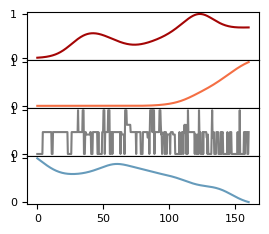

In [119]:
import matplotlib.pyplot as plt
import random
from matplotlib.gridspec import GridSpec
case4_with_size_med = with_size4.loc[with_size4['cell1 vs. cell1']==with_size4['cell1 vs. cell1'][0:99].median()].index[0]
case4_without_size_med = without_size4.loc[without_size4['cell1 vs. cell1']==without_size4['cell1 vs. cell1'][0:99].median()].index[0]
case4_squidpy_med = squidpy4.loc[squidpy4['cell1 vs. cell1']==squidpy4['cell1 vs. cell1'][0:99].median()].index[0]
case4_spatstat_med = spatstat4.loc[spatstat4['cell1 vs. cell1']==spatstat4['cell1 vs. cell1'][0:99].median()].index[0]
case4_med = [case4_with_size_med,case4_without_size_med,case4_squidpy_med,case4_spatstat_med]
# Create a figure and a GridSpec object
plt.rcParams.update({'font.size': 8})
fig = plt.figure()
fig.set_size_inches(3, 2.5)
gs = GridSpec(4, 1, hspace=0, wspace=0)

# Create subplots using the GridSpec object
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[3, 0])

xrange = [0,330]
yrange = [0,330]
W = window(xrange,yrange)
# with size considered
random.seed(case4_med[0])
x1 = []
y1 = []
x2 = []
y2 = []
for i in range(0,50):
    n = random.randint(0, 200)
    x1.append(n)
    n = random.randint(0, 200)
    y1.append(n)
    n = random.randint(150, 330)
    x2.append(n)
    n = random.randint(150, 330)
    y2.append(n)
mark1 = []
mark2 = []
for i in range(0,50):
    n = random.randint(1,5)
    mark1.append(1)
    n = random.randint(1,5)
    mark2.append(2)
d1 = [3]*len(x1)
adipocyte_x = [35,110,30,150,200,230,280,80,30,200,300,130,270,180]
adipocyte_y = [27,60,100,150,300,220,50,190,260,80,280,230,130,0]
rm_idx = []
for i in range(len(x1)):
    for j in range(len(adipocyte_x)):
        d2_0 = (x1[i]-adipocyte_x[j])**2 + (y1[i]-adipocyte_y[j])**2
        if d2_0 < 1681:
            rm_idx.append(i)
x1 = np.delete(x1,rm_idx).tolist()
y1 = np.delete(y1,rm_idx).tolist()
mark1 = np.delete(mark1,rm_idx).tolist()
d1 = np.delete(d1,rm_idx).tolist()

d2 = [3]*len(x2)
rm_idx = []
for i in range(len(x2)):
    for j in range(len(adipocyte_x)):
        d2_0 = (x2[i]-adipocyte_x[j])**2 + (y2[i]-adipocyte_y[j])**2
        if d2_0 < 1681:
            rm_idx.append(i)
x2 = np.delete(x2,rm_idx).tolist()
y2 = np.delete(y2,rm_idx).tolist()
mark2 = np.delete(mark2,rm_idx).tolist()
d2 = np.delete(d2,rm_idx).tolist()

x=x1+x2
y=y1+y2
d=d1+d2

mark_1 = mark1+[0]*len(mark2)
mark_2 = [0]*len(mark1)+mark2
mark = pd.DataFrame()
mark["cell1"] = mark_1
mark["cell2"] = mark_2
p = pointPattern(x,y,d,W,mark)
r, funs = markcorr.markcorr(p, saveImage=False,savefolder = "./", remove_zeros=False, plot=False)
iso, trans = {}, {}
for i in funs:
    trans[i] = (funs[i][0])
    iso[i] = (funs[i][1])
trans = pd.DataFrame(trans)
trans["r"] = r

v = trans['cell1 vs. cell2']
v = (v - v.min()) / (v.max() - v.min())
x = trans.r[trans.r<160].to_list()
y = v[trans.r<160].to_list()
ax1.plot(x, y,color="#a40505")

# without size considered
random.seed(case4_med[1])
x1 = []
y1 = []
x2 = []
y2 = []
for i in range(0,50):
    n = random.randint(0, 200)
    x1.append(n)
    n = random.randint(0, 200)
    y1.append(n)
    n = random.randint(150, 330)
    x2.append(n)
    n = random.randint(150, 330)
    y2.append(n)
mark1 = []
mark2 = []
for i in range(0,50):
    n = random.randint(1,5)
    mark1.append(1)
    n = random.randint(1,5)
    mark2.append(2)
d1 = [3]*len(x1)
adipocyte_x = [35,110,30,150,200,230,280,80,30,200,300,130,270,180]
adipocyte_y = [27,60,100,150,300,220,50,190,260,80,280,230,130,0]
rm_idx = []
for i in range(len(x1)):
    for j in range(len(adipocyte_x)):
        d2_0 = (x1[i]-adipocyte_x[j])**2 + (y1[i]-adipocyte_y[j])**2
        if d2_0 < 1681:
            rm_idx.append(i)
x1 = np.delete(x1,rm_idx).tolist()
y1 = np.delete(y1,rm_idx).tolist()
mark1 = np.delete(mark1,rm_idx).tolist()
d1 = np.delete(d1,rm_idx).tolist()

d2 = [3]*len(x2)
rm_idx = []
for i in range(len(x2)):
    for j in range(len(adipocyte_x)):
        d2_0 = (x2[i]-adipocyte_x[j])**2 + (y2[i]-adipocyte_y[j])**2
        if d2_0 < 1681:
            rm_idx.append(i)
x2 = np.delete(x2,rm_idx).tolist()
y2 = np.delete(y2,rm_idx).tolist()
mark2 = np.delete(mark2,rm_idx).tolist()
d2 = np.delete(d2,rm_idx).tolist()

x=x1+x2
y=y1+y2
d = None

mark_1 = mark1+[0]*len(mark2)
mark_2 = [0]*len(mark1)+mark2
mark = pd.DataFrame()
mark["cell1"] = mark_1
mark["cell2"] = mark_2
p = pointPattern(x,y,d,W,mark)
r, funs = markcorr.markcorr(p, saveImage=False,savefolder = "./", remove_zeros=False, plot=False)
iso, trans = {}, {}
for i in funs:
    trans[i] = (funs[i][0])
    iso[i] = (funs[i][1])
trans = pd.DataFrame(trans)
trans["r"] = r

v = trans['cell1 vs. cell2']
v = (v - v.min()) / (v.max() - v.min())
x = trans.r[trans.r<160].to_list()
y = v[trans.r<160].to_list()
ax2.plot(x, y,color="#f46f44")

# Squidpy
random.seed(case4_med[2])
x1 = []
y1 = []
x2 = []
y2 = []
for i in range(0,50):
    n = random.randint(0, 200)
    x1.append(n)
    n = random.randint(0, 200)
    y1.append(n)
    n = random.randint(150, 330)
    x2.append(n)
    n = random.randint(150, 330)
    y2.append(n)
adipocyte_x = [35,110,30,150,200,230,280,80,30,200,300,130,270,180]
adipocyte_y = [27,60,100,150,300,220,50,190,260,80,280,230,130,0]
rm_idx = []
for i in range(len(x1)):
    for j in range(len(adipocyte_x)):
        d2_0 = (x1[i]-adipocyte_x[j])**2 + (y1[i]-adipocyte_y[j])**2
        if d2_0 < 1681:
            rm_idx.append(i)
x1 = np.delete(x1,rm_idx).tolist()
y1 = np.delete(y1,rm_idx).tolist()
rm_idx = []
for i in range(len(x2)):
    for j in range(len(adipocyte_x)):
        d2_0 = (x2[i]-adipocyte_x[j])**2 + (y2[i]-adipocyte_y[j])**2
        if d2_0 < 1681:
            rm_idx.append(i)
x2 = np.delete(x2,rm_idx).tolist()
y2 = np.delete(y2,rm_idx).tolist()

x=x1+x2
y=y1+y2
spatial_squidpy = []
for i in range(len(x1)):
    spatial_squidpy.append([x1[i],y1[i]])
for i in range(len(x2)):
    spatial_squidpy.append([x2[i],y2[i]])
# for i in range(len(adipocyte_x)):
#     spatial.append([adipocyte_x[i],adipocyte_y[i]])
cell_type_colors = ["#c82423","#3B5284"]

cell_type = ["cell1"]*len(x1)+["cell2"]*len(x2)
cell_type=pd.DataFrame(cell_type,columns =['cell_type'])
spatial_squidpy=np.array(spatial_squidpy)

counts = csr_matrix(np.random.poisson(1, size=(len(x1)+len(x2),10)), dtype=np.float32)
adata = anndata.AnnData(counts)
adata.obs = cell_type.astype('category')
adata.uns = {"cell_type_colors":cell_type_colors}
adata.obsm["spatial"] = spatial_squidpy
interval_far = np.linspace(0, 160, 500)
sq.gr.co_occurrence(adata, cluster_key="cell_type",interval=interval_far)
plt_squidpy = plt_co_occurrence(
        adata,
        cluster_key="cell_type",
        clusters=["cell1", "cell2"])
ax3.plot(plt_squidpy["r"], plt_squidpy["kmm"],color="grey")


# spatstat
random.seed(case4_med[3])
x1 = []
y1 = []
x2 = []
y2 = []
for i in range(0,50):
    n = random.randint(0, 200)
    x1.append(n)
    n = random.randint(0, 200)
    y1.append(n)
    n = random.randint(150, 330)
    x2.append(n)
    n = random.randint(150, 330)
    y2.append(n)
mark1 = []
mark2 = []
for i in range(0,50):
    n = random.randint(1,5)
    mark1.append(1)
    n = random.randint(1,5)
    mark2.append(2)
adipocyte_x = [35,110,30,150,200,230,280,80,30,200,300,130,270,180]
adipocyte_y = [27,60,100,150,300,220,50,190,260,80,280,230,130,0]
rm_idx = []
d1 = [3]*len(x1)
for i in range(len(x1)):
    for j in range(len(adipocyte_x)):
        d2_0 = (x1[i]-adipocyte_x[j])**2 + (y1[i]-adipocyte_y[j])**2
        if d2_0 < 1681:
            rm_idx.append(i)
x1 = np.delete(x1,rm_idx).tolist()
y1 = np.delete(y1,rm_idx).tolist()
mark1 = np.delete(mark1,rm_idx).tolist()
d1 = np.delete(d1,rm_idx).tolist()

d2 = [3]*len(x2)
rm_idx = []
for i in range(len(x2)):
    for j in range(len(adipocyte_x)):
        d2_0 = (x2[i]-adipocyte_x[j])**2 + (y2[i]-adipocyte_y[j])**2
        if d2_0 < 1681:
            rm_idx.append(i)
x2 = np.delete(x2,rm_idx).tolist()
y2 = np.delete(y2,rm_idx).tolist()
mark2 = np.delete(mark2,rm_idx).tolist()
d2 = np.delete(d2,rm_idx).tolist()

x=x1+x2
y=y1+y2
mark_1 = mark1+[0]*len(mark2)
mark_2 = [0]*len(mark1)+mark2
mark = pd.DataFrame()
mark["cell1"] = mark_1
mark["cell2"] = mark_2
spatial = pd.DataFrame([x,y,mark_1,mark_2]).transpose()
spatial.columns=["x","y","mark1","mark2"]
spatial.to_csv("./benchmark4_med.csv")

# run spatstat on the data to get plot
spatstat_med = pd.read_csv("spatstat_med4.csv")
ax4.plot(spatstat_med["r"], spatstat_med["med4"],color="#669bbb")
plt.savefig("bm4_line.svg")

In [1]:
import sys
import altair as alt
sys.path.append("./altairThemes.py")

if True:  # In order to bypass isort when saving
    import altairThemes

# register the custom theme under a chosen name
alt.themes.register("publishTheme", altairThemes.publishTheme)

# enable the newly registered theme
alt.themes.enable("publishTheme")

ThemeRegistry.enable('publishTheme')

In [30]:
from sklearn.decomposition import PCA
def plot_3d_pca(auc_r):
    auc_r=auc_r.reset_index()
    auc_r=auc_r.fillna(0)
    auc_r = auc_r.drop('index', axis=1)
    pca_r = PCA(n_components=3)
    pca_r_fit = pca_r.fit_transform(auc_r)
    principal_Df = pd.DataFrame(data = pca_r_fit)
    plt.figure()
    plt.figure(figsize=(3.5,3.5))
    ax = plt.axes(projection='3d')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)
    ax.set_xlabel("PC1",fontsize=9)
    ax.set_ylabel("PC2",fontsize=9)
    ax.set_zlabel("PC3",fontsize=9)
    plt.title("3D Principal Component Analysis",fontsize=9)
    targets = ["1","0"]
    colors = ['#a1dab4', '#fefebb']
    print('Explained variation; per principal component: {}'.format(pca_r.explained_variance_ratio_))
    for target, color in zip(targets,colors):
        indicesToKeep = np.where(auc_r["label"] == target)[0]
        ax.scatter(principal_Df.iloc[indicesToKeep, 0]
                , principal_Df.iloc[indicesToKeep, 1], principal_Df.iloc[indicesToKeep, 2], c = color, edgecolors='black')
    plt.legend(["AML","NBM"],prop={'size': 9})
    plt.savefig("3d_pca.svg")
    return pd.DataFrame(data = pca_r_fit)

def plot_2d_pca(auc_r):
    auc_r=auc_r.reset_index()
    auc_r=auc_r.fillna(0)
    auc_r = auc_r.drop('index', axis=1)
    pca_r = PCA(n_components=2)
    pca_r_fit = pca_r.fit_transform(auc_r)
    principal_Df = pd.DataFrame(data = pca_r_fit)
    plt.figure()
    plt.figure(figsize=(2.5,2.5))
    ax = plt.axes(projection=None)
    ax.set_xlabel("PC1",fontsize=8)
    ax.set_ylabel("PC2",fontsize=8)
    targets = ["1","0"]
    colors = ['#a1dab4', '#fefebb']
    print('Explained variation; per principal component: {}'.format(pca_r.explained_variance_ratio_))
    for target, color in zip(targets,colors):
        indicesToKeep = np.where(auc_r["label"] == target)[0]
        ax.scatter(principal_Df.iloc[indicesToKeep, 0]
                , principal_Df.iloc[indicesToKeep, 1], c = color, edgecolors='black')
    plt.legend(["AML","NBM"],prop={'size': 8})
    plt.savefig("2d_pca.svg")
    return pd.DataFrame(data = pca_r_fit)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

auc_normal_r = pd.DataFrame()
for i in range(15):  
    isoResult = pd.read_csv("./result2/Normal/image_%d/iso.csv"%i).drop(["Unnamed: 0"], axis=1)
    isoMin = isoResult.where(isoResult > 0).min().min()
    logRes = np.log2(isoResult.where(isoResult > 0, isoMin))
    auc_normal_r["image_%d"%i] = logRes.sum(axis = 0)
auc_normal_r = auc_normal_r[auc_normal_r != 0]
auc_normal_r = auc_normal_r.transpose()
auc_normal_r["label"] = "0"

auc_aml_r = pd.DataFrame()
for i in range(36):  
    isoResult = pd.read_csv("./result2/AML/image_%d/iso.csv"%i).drop(["Unnamed: 0"], axis=1)
    isoMin = isoResult.where(isoResult > 0).min().min()
    logRes = np.log2(isoResult.where(isoResult > 0, isoMin))
    auc_aml_r["image_%d"%i] = logRes.sum()
auc_aml_r = auc_aml_r[auc_aml_r != 0]
auc_aml_r = auc_aml_r.transpose()
auc_aml_r["label"] = "1"
auc_r = pd.concat([auc_normal_r, auc_aml_r], axis=0)

/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/scikit_learn-1.2.0rc1-py3.10-linux-x86_64.egg/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/scikit_learn-1.2.0rc1-py3.10-linux-x86_64.egg/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/scikit_learn-1.2.0rc1-py3.10-linux-x86_64.egg/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Explained variation; per principal component: [0.32437141 0.29082648]


,0,1
0,-5702.814176,-2984.007774
1,-4848.347721,2350.613350
2,-6739.777629,-3660.961519
3,-7727.273326,-2443.557407
4,9388.903784,11116.460473
5,-3057.003394,1291.054054
6,-1645.669431,3465.124751
7,-1134.550351,6787.410880
8,5324.469310,10271.557290
9,-6491.696166,472.903387


<Figure size 640x480 with 0 Axes>

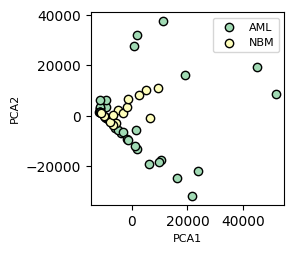

In [15]:
plot_2d_pca(auc_r)

In [25]:
auc_r=auc_r.reset_index()
auc_r=auc_r.fillna(0)
auc_r = auc_r.drop('index', axis=1)
pca_r = PCA(n_components=2)
pca_r_fit = pca_r.fit_transform(auc_r)
principal_Df = pd.DataFrame(data = pca_r_fit)
principal_Df.columns = ["PC1","PC2"]
principal_Df["label"] = ["NBM"]*15+["AML"]*36
alt.Chart(principal_Df).mark_point().encode(
    x=alt.X("PC1:Q",axis=alt.Axis(tickCount=5,format=".1e")),
    y=alt.Y("PC2:Q",axis=alt.Axis(tickCount=5,format=".1e")),
    color=alt.value('black'),
    fill=alt.Color("label",scale=alt.Scale(domain=["AML","NBM"],range=['#a1dab4', '#fefebb']))
)
plt.savefig("2d_pca.svg")

/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/scikit_learn-1.2.0rc1-py3.10-linux-x86_64.egg/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/scikit_learn-1.2.0rc1-py3.10-linux-x86_64.egg/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/scikit_learn-1.2.0rc1-py3.10-linux-x86_64.egg/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/emm

alt.Chart(...)

/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/scikit_learn-1.2.0rc1-py3.10-linux-x86_64.egg/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/scikit_learn-1.2.0rc1-py3.10-linux-x86_64.egg/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/scikit_learn-1.2.0rc1-py3.10-linux-x86_64.egg/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Explained variation; per principal component: [0.32437141 0.29082648 0.14116678]


<Figure size 640x480 with 0 Axes>

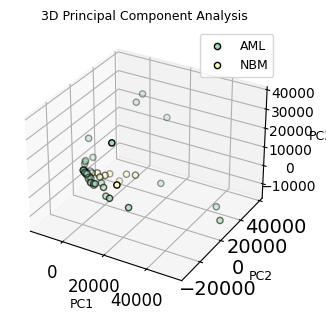

In [31]:
principal_Df = plot_3d_pca(auc_r)

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

auc_normal_r = pd.DataFrame()
patient_label = []
for i in range(15):  
    isoResult = pd.read_csv("./result2/Normal/image_%d/iso.csv"%i).drop(["Unnamed: 0"], axis=1)
    isoMin = isoResult.where(isoResult > 0).min().min()
    logRes = np.log2(isoResult.where(isoResult > 0, isoMin))
    patient_num = i//3+1
    patient_label.append(str(patient_num))
    roi_num = i%3+1
    index = "Normal_patient_"+str(patient_num)+"_ROI_"+str(roi_num)
    auc_normal_r[index] = logRes.sum(axis = 0)
auc_normal_r.loc['patient_label'] = patient_label
auc_normal_r = auc_normal_r[auc_normal_r != 0]
auc_normal_r = auc_normal_r.transpose()
auc_normal_r["label"] = "0"

auc_aml_r = pd.DataFrame()
patient_label = []
for i in range(36):  
    isoResult = pd.read_csv("./result2/AML/image_%d/iso.csv"%i).drop(["Unnamed: 0"], axis=1)
    isoMin = isoResult.where(isoResult > 0).min().min()
    logRes = np.log2(isoResult.where(isoResult > 0, isoMin))
    patient_num = i//3
    roi_num = i%3+1
    patient_label.append(str(patient_num+6))
    index = "AML_patient_"+str(patient_num)+"_ROI_"+str(roi_num)
    auc_aml_r[index] = logRes.sum()
auc_aml_r.loc['patient_label'] = patient_label
auc_aml_r = auc_aml_r[auc_aml_r != 0]
auc_aml_r = auc_aml_r.transpose()
auc_aml_r["label"] = "1"


auc_r = pd.concat([auc_normal_r, auc_aml_r], axis=0)
field = auc_r.columns
cell_to_marker = {  "HSC" : "CD34", "MSC" : "NGFR", 
                  "Macrophages" : "CD163", "Megakaryocytes" : "CD31", "Monocytes" : "CD68", "Myeloids" : "MPO", "T_cells" : "CD3"}
new_field = []
for feature in field:
    # print(feature)
    feature = feature.replace('Intensity_','')
    feature = feature.replace('CD20','B_cells')
    feature = feature.replace('CD34','HSC')
    feature = feature.replace('NGFR','MSC')
    feature = feature.replace('CD163','Macrophages')
    feature = feature.replace('CD31','Megakaryocytes')
    feature = feature.replace('CD68','Monocytes')
    feature = feature.replace('MPO','Myeloids')
    feature = feature.replace('CD3','T_cells')
    new_field.append(feature)
    
new_field
auc_r.columns = new_field

/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/scikit_learn-1.2.0rc1-py3.10-linux-x86_64.egg/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/scikit_learn-1.2.0rc1-py3.10-linux-x86_64.egg/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/scikit_learn-1.2.0rc1-py3.10-linux-x86_64.egg/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Explained variation; per principal component: [0.3243714  0.29082648 0.14116677]
Explained variation; per principal component: [0.3243714  0.29082648 0.14116677]


<Figure size 640x480 with 0 Axes>

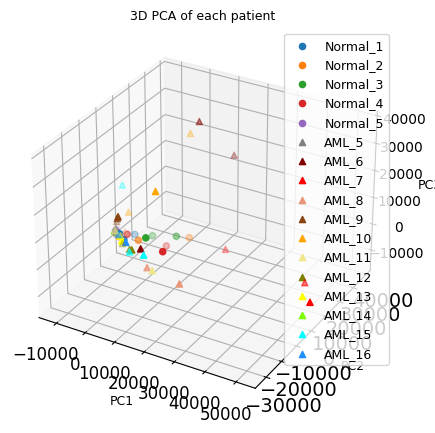

In [52]:
from mpl_toolkits import mplot3d
import random
def random_color_generator(fraction):
    # r = (255-150) * fraction + 150
    # g = (155-120) * fraction  + 120
    # b = (255-130)* fraction + 130
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

def plot_aml_pca(auc_r):
    # plt.scatter(auc_r[component1], auc_r[component2])
    auc_r=auc_r.reset_index()
    auc_r=auc_r.fillna(0)
    auc_r = auc_r.drop('index', axis=1)
    # print(auc_r)
    pca_r = PCA(n_components=3)
    # auc_r_select = auc_r
    pca_r_fit = pca_r.fit_transform(auc_r)
    principal_Df = pd.DataFrame(data = pca_r_fit)
    # print(principal_Df)
    plt.figure()
    plt.figure(figsize=(5,5))
    ax = plt.axes(projection='3d')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)
    ax.set_xlabel("PC1",fontsize=9)
    ax.set_ylabel("PC2",fontsize=9)
    ax.set_zlabel("PC3",fontsize=9)
    plt.title("3D PCA of each patient",fontsize=9)
    targets = []
    targets_name = []
    colors = []


    # the starting color
    initial_color = (0.60156, 0, 0.99218)  # (154, 0, 254)

    # the final, target color
    target_color = (0.86328, 0.47656, 0.31250)  # (221, 122, 80)
    deltas=[(target_color[i] - initial_color[i])/17 for i in range(3)]
    for j in range(0, 5):
        interpolated_color=tuple([initial_color[i] + (deltas[i] * j) for i in range(3)])
        colors.append(interpolated_color)



    for i in range(0,5):
        targets.append(str(i))
        if i<5:
            targets_name.append("Normal_"+str(i+1))
        else:
            targets_name.append("AML_"+str(i+6))
    print('Explained variation; per principal component: {}'.format(pca_r.explained_variance_ratio_))
    for target, color in zip(targets_name,colors):
        indicesToKeep = np.where(auc_r["patient_label"] == target.strip().split('_')[1])[0]
        ax.scatter(principal_Df.iloc[indicesToKeep, 0]
                , principal_Df.iloc[indicesToKeep, 1], principal_Df.iloc[indicesToKeep, 2])
    plt.legend(targets_name,prop={'size': 9})



    for j in range(5,17):
        interpolated_color=tuple([initial_color[i] + (deltas[i] * j) for i in range(3)])
        colors.append(interpolated_color)


    for i in range(5,17):
        targets.append(str(i))
        targets_name.append("AML_"+str(i))
    print('Explained variation; per principal component: {}'.format(pca_r.explained_variance_ratio_))    
    colors = ["blueviolet","fuchsia","lightcoral","sienna","peru","gray","maroon","red","darksalmon","saddlebrown","orange","khaki","olive",
              "yellow","lawngreen","cyan","dodgerblue"]
    i=0
    for target, color in zip(targets_name,colors):
        if i<5:
            i=i+1
            continue
        indicesToKeep = np.where(auc_r["patient_label"] == target.strip().split('_')[1])[0]
        ax.scatter(principal_Df.iloc[indicesToKeep, 0], principal_Df.iloc[indicesToKeep, 1], principal_Df.iloc[indicesToKeep, 2], marker = "^",c=color)
    plt.legend(targets_name,prop={'size': 9})
    
    plt.savefig("3d_pca_each_patient.svg")
    return principal_Df

principal_Df=plot_aml_pca(auc_r)

/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/scikit_learn-1.2.0rc1-py3.10-linux-x86_64.egg/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/scikit_learn-1.2.0rc1-py3.10-linux-x86_64.egg/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/scikit_learn-1.2.0rc1-py3.10-linux-x86_64.egg/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Explained variation; per principal component: [0.3243714  0.29082648]
Explained variation; per principal component: [0.3243714  0.29082648]


<Figure size 640x480 with 0 Axes>

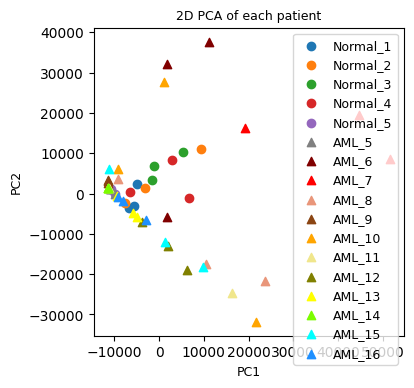

In [53]:
def plot_pca_2d(auc_r):
    # plt.scatter(auc_r[component1], auc_r[component2])
    auc_r=auc_r.reset_index()
    auc_r=auc_r.fillna(0)
    auc_r = auc_r.drop('index', axis=1)
    # print(auc_r)
    pca_r = PCA(n_components=2)
    # auc_r_select = auc_r
    pca_r_fit = pca_r.fit_transform(auc_r)
    principal_Df = pd.DataFrame(data = pca_r_fit)
    # print(principal_Df)
    plt.figure()
    plt.figure(figsize=(4,4))
    # plt.xticks(fontsize=12)
    # plt.yticks(fontsize=14)
    ax = plt.axes(projection=None)
    ax.set_xlabel("PC1",fontsize=9)
    ax.set_ylabel("PC2",fontsize=9)
    plt.title("2D PCA of each patient",fontsize=9)
    targets = []
    targets_name = []
    colors = []


    # the starting color
    initial_color = (0.60156, 0, 0.99218)  # (154, 0, 254)

    # the final, target color
    target_color = (0.86328, 0.47656, 0.31250)  # (221, 122, 80)
    deltas=[(target_color[i] - initial_color[i])/17 for i in range(3)]
    for j in range(0, 5):
        interpolated_color=tuple([initial_color[i] + (deltas[i] * j) for i in range(3)])
        colors.append(interpolated_color)



    for i in range(0,5):
        targets.append(str(i))
        targets_name.append("Normal_"+str(i+1))
    print('Explained variation; per principal component: {}'.format(pca_r.explained_variance_ratio_))
    for target, color in zip(targets_name,colors):
        indicesToKeep = np.where(auc_r["patient_label"] == target.strip().split('_')[1])[0]
        ax.scatter(principal_Df.iloc[indicesToKeep, 0], principal_Df.iloc[indicesToKeep, 1])
    plt.legend(targets_name,prop={'size': 10})



    for j in range(5,17):
        interpolated_color=tuple([initial_color[i] + (deltas[i] * j) for i in range(3)])
        colors.append(interpolated_color)


    for i in range(5,17):
        targets.append(str(i))
        targets_name.append("AML_"+str(i))
    print('Explained variation; per principal component: {}'.format(pca_r.explained_variance_ratio_))
    colors = ["blueviolet","fuchsia","lightcoral","sienna","peru","gray","maroon","red","darksalmon","saddlebrown","orange","khaki","olive",
              "yellow","lawngreen","cyan","dodgerblue"]
    i=0
    for target, color in zip(targets_name,colors):
        if i<5:
            i=i+1
            continue
        indicesToKeep = np.where(auc_r["patient_label"] == target.strip().split('_')[1])[0]
        ax.scatter(principal_Df.iloc[indicesToKeep, 0], principal_Df.iloc[indicesToKeep, 1], marker = "^", c=color)
    plt.legend(targets_name,prop={'size': 9})
    plt.savefig("2d_pca_each_patient.svg")
    return principal_Df

principal_Df=plot_pca_2d(auc_r)

In [34]:
plt.figure(figsize=[2.5,2.5])
# principal_Df = plot_3d_pca(auc_r)
principal_Df_normal = principal_Df[0:16]
principal_Df_aml = principal_Df[16:]
x_n = principal_Df_normal[0].tolist()
y_n = principal_Df_normal[1].tolist()
z_n = principal_Df_normal[2].tolist()
x_a = principal_Df_aml[0].tolist()
y_a = principal_Df_aml[1].tolist()
z_a = principal_Df_aml[2].tolist()
import math
from itertools import combinations
import numpy as np


def dist(p1, p2):
    [x1, y1, z1], [x2, y2, z2] = p1, p2
    p1 = np.array(p1)
    p2 = np.array(p2)
    squared_dist = np.sum((p1-p2)**2, axis=0)
    dist = np.sqrt(squared_dist)
    return dist


points_n = list(zip(x_n,y_n,z_n))
distances_n = [dist(p1, p2) for p1, p2 in combinations(points_n, 2)]
avg_distance_n = sum(distances_n) / len(distances_n)
print(avg_distance_n)


points_a = list(zip(x_a,y_a,z_a))
distances_a = [dist(p1, p2) for p1, p2 in combinations(points_a, 2)]
avg_distance_a = sum(distances_a) / len(distances_a)
print(avg_distance_a)
bars = [avg_distance_n,avg_distance_a]
x_pos = np.arange(len(bars))
# plt.bar(x_pos, bars,color=['red', 'green'], width=0.2)
# plt.xticks(x_pos, ("normal","aml"))
values = pd.DataFrame(distances_a+distances_n)
values.columns = ["distance"]
# values = values.T
groups = ['AML','NBM']
values["label"] = ["AML"]*len(distances_a)+["NBM"]*len(distances_n)
alt.Chart(values).mark_boxplot(extent="min-max").encode(
    alt.X("label:N"),
    alt.Y("distance:Q"),
    alt.Color("label",scale=alt.Scale(domain=["AML","NBM"],range=['#a1dab4', '#fefebb']))
)
# plt.title("Average distance of all patients")
# plt.show()
plt.savefig("avg_patients.svg")

14267.972262222316
26068.504327885952


<Figure size 250x250 with 0 Axes>

In [ ]:
normal_average=[]
aml_average=[]
for i in range(0,5,1):
    x_n = principal_Df_normal[i:i+3][0].tolist()
    y_n = principal_Df_normal[i:i+3][1].tolist()
    z_n = principal_Df_normal[i:i+3][2].tolist()
    points_n = list(zip(x_n,y_n,z_n))
    distances_n = [dist(p1, p2) for p1, p2 in combinations(points_n, 2)]
    avg_distance_n = sum(distances_n) / len(distances_n)
    normal_average.append(avg_distance_n)
    # aml_average.append(0)
for i in range(0,12,1):
    x_a = principal_Df_aml[i:i+3][0].tolist()
    y_a = principal_Df_aml[i:i+3][1].tolist()
    z_a = principal_Df_aml[i:i+3][2].tolist()
    points_a = list(zip(x_a,y_a,z_a))
    distances_a = [dist(p1, p2) for p1, p2 in combinations(points_a, 2)]
    avg_distance_a = sum(distances_a) / len(distances_a)
    aml_average.append(avg_distance_a)
    # normal_average.append(0)

values = np.array([aml_average,normal_average])
values = values.T
groups = ['AML','NBM']
bplot = plt.boxplot(values,labels=groups,patch_artist=True)
colors=['#a1dab4', '#fefebb']
for patch, color in zip(bplot['boxes'], colors):
    patch.set(color=color)
plt.title("Average distance of each patient")
# plt.show()
plt.savefig("boxplot_each_patients.svg")

In [38]:
normal_average=[]
aml_average=[]
for i in range(0,5,1):
    x_n = principal_Df_normal[i:i+3][0].tolist()
    y_n = principal_Df_normal[i:i+3][1].tolist()
    z_n = principal_Df_normal[i:i+3][2].tolist()
    points_n = list(zip(x_n,y_n,z_n))
    distances_n = [dist(p1, p2) for p1, p2 in combinations(points_n, 2)]
    avg_distance_n = sum(distances_n) / len(distances_n)
    normal_average.append(avg_distance_n)
    # aml_average.append(0)
for i in range(0,12,1):
    x_a = principal_Df_aml[i:i+3][0].tolist()
    y_a = principal_Df_aml[i:i+3][1].tolist()
    z_a = principal_Df_aml[i:i+3][2].tolist()
    points_a = list(zip(x_a,y_a,z_a))
    distances_a = [dist(p1, p2) for p1, p2 in combinations(points_a, 2)]
    avg_distance_a = sum(distances_a) / len(distances_a)
    aml_average.append(avg_distance_a)
    # normal_average.append(0)

values = pd.DataFrame(aml_average+normal_average)
values.columns = ["distance"]
values["label"] = ["AML"]*len(aml_average)+["NBM"]*len(normal_average)
alt.Chart(values).mark_boxplot(extent="min-max").encode(
    alt.X("label:N"),
    alt.Y("distance:Q"),
    alt.Color("label",scale=alt.Scale(domain=["AML","NBM"],range=['#a1dab4', '#fefebb']))
)
plt.savefig("avg_each_patients.svg")

<Figure size 640x480 with 0 Axes>

/tmp/ipykernel_1030/1909210710.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([aml_average,normal_average])


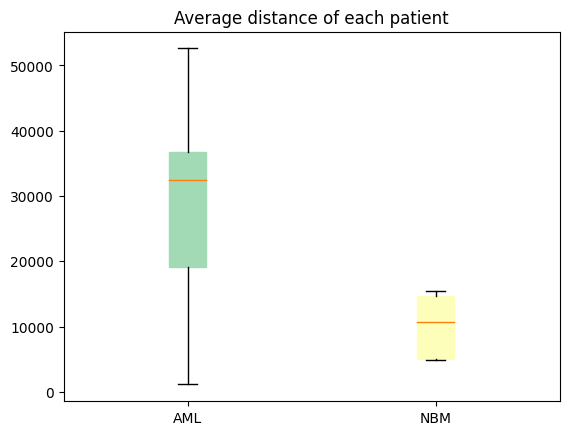

In [18]:
normal_average=[]
aml_average=[]
for i in range(0,5,1):
    x_n = principal_Df_normal[i:i+3][0].tolist()
    y_n = principal_Df_normal[i:i+3][1].tolist()
    z_n = principal_Df_normal[i:i+3][2].tolist()
    points_n = list(zip(x_n,y_n,z_n))
    distances_n = [dist(p1, p2) for p1, p2 in combinations(points_n, 2)]
    avg_distance_n = sum(distances_n) / len(distances_n)
    normal_average.append(avg_distance_n)
    # aml_average.append(0)
for i in range(0,12,1):
    x_a = principal_Df_aml[i:i+3][0].tolist()
    y_a = principal_Df_aml[i:i+3][1].tolist()
    z_a = principal_Df_aml[i:i+3][2].tolist()
    points_a = list(zip(x_a,y_a,z_a))
    distances_a = [dist(p1, p2) for p1, p2 in combinations(points_a, 2)]
    avg_distance_a = sum(distances_a) / len(distances_a)
    aml_average.append(avg_distance_a)
    # normal_average.append(0)

values = np.array([aml_average,normal_average])
values = values.T
groups = ['AML','NBM']
bplot = plt.boxplot(values,labels=groups,patch_artist=True)
colors=['#a1dab4', '#fefebb']
for patch, color in zip(bplot['boxes'], colors):
    patch.set(color=color)
plt.title("Average distance of each patient")
# plt.show()
plt.savefig("boxplot_each_patients.svg")